# NGC 104 (47 Tuc) Notebook

- NGC 6121
- [X] NGC 104
- NGC 6656
- NGC 6544

## Initialization

In [6]:
import os
import grasp
import numpy as np
import pandas as pd
from astropy import units as u
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
dr3 = grasp.dr3()
gc = grasp.Cluster('ngc104')
f = grasp.load_base_formulary()

gplt = grasp.plots
stats = grasp.stats

scan_radius = gc.rt.value * 1.2

gc.rt_pc = gc.dist.to(u.pc) * np.tan(gc.rt.to(u.rad))



            ..............
         ..:;;..:;;;;;:::::;;
       ;;;;;;::.::;;;;;;;;;;;;;
      ;;;;.:;;;..;XXXXXX.::....:           GAIA QUERY MODULE
     :;::;::..+XXXXXXXXX+:;;;;;;:
    ;::;:.:;;:XXXXXXXXXXX::::::::;        __ _  __ _(_) __ _
    .;;..;;;:.:XXXXXXXXX$$$$$$$$$$X.     / _` |/ _` | |/ _` |
    :;..:;;;..:xXXXXXXX$$$$$$$$$$$$X    | (_| | (_| | | (_| |
    :;:.:;;.XXXXXXXXX$$$$$$$$$$$$$$;     \__, |\__,_|_|\__,_|
    .;;:.:X$$$$$$$$$$$$$$$$$$$$$$X.      |___/
    ..:;:$$$$$$$$$$$$$$$$$$$$$$X;.
     :;;;$$$$$$$$$$$$$$$$$$$$::;;             INITIALIZED
      ...;$$$$$$$$$$$$$$x;:;;;;;
        ......:;:....;;;;;;;:.
          ::::::::::;;;::...
            ....::::.....

Initialized with Gaia table: 'gaiadr3.gaia_source'


In [8]:
fas = dr3.get_astrometry(
    radius=scan_radius, 
    gc=gc, 
    save=True, 
    add_data="ra_dec_corr, pmra_pmdec_corr, phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved",
    conditions='astrometric_params_solved != 3',)
fas.info()


INFO: Query finished. [astroquery.utils.tap.core]
Sample number of sources: 166974
/home/pietrof/graspdata/query/NGC104/20250602_114728/query_data.fits
/home/pietrof/graspdata/query/NGC104/20250602_114728/query_info.ini
<Sample length=166974>
           name            dtype    unit                                        description                                          class      n_bad
------------------------- ------- -------- ------------------------------------------------------------------------------------- -------------- -----
                SOURCE_ID   int64                             Unique source identifier (unique within a particular Data Release)   MaskedColumn     0
                       ra float64      deg                                                                       Right ascension MaskedQuantity     0
                 ra_error float32      mas                                                     Standard error of right ascension MaskedQuantity     0
       

In [14]:
Nneg = len(fas.to_pandas()[fas['parallax']<0])

grasp.zero_point_correction(sample=fas)

Nneg_f = len(fas.to_pandas()[fas['parallax']<0])

print(f"Saved stars from negative parallax: {Nneg-Nneg_f} ({(1-Nneg_f/Nneg)*100:.2f}%)")


Using the "Zero Point Correction" tool from Pau Ramos
(Lindergren, et al., A&A 649, A4 (2021)
Parallaxes already corrected with the ZP algorithm.
Saved stars from negative parallax: 0 (0.00%)


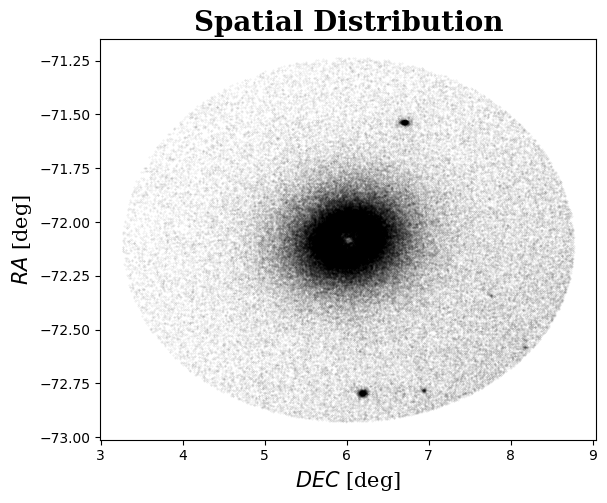

(<Figure size 640x520 with 1 Axes>,
 <Axes: title={'center': 'Spatial Distribution'}, xlabel='$DEC$ [deg]', ylabel='$RA$ [deg]'>)

In [15]:
gplt.spatial(fas, size=0.1, alpha=.1, axis=None)

# MachineLearning

**TARGET PARAMETERS** (B&V21 from the <a href=https://github.com/GalacticDynamics-Oxford/GaiaTools/tree/master> GaiaTools</a> results)

> $ \bar{\omega} = 0.232 \pm  0.009$

> $ \mathrm{pmra} = 5.259 \pm 0.025$

> $ \mathrm{pmdec} = -2.543 \pm 0.025$

## GMM on Full Sample

### Feature Engeneering

In [4]:
useless_columns = ["phot_g_mean_mag,nu_eff_used_in_astrometry,pseudocolour,ecl_lat,astrometric_params_solved"]
for c in useless_columns:
    if c in fas.columns:
        fas.drop_column(c)
fas.dropna()

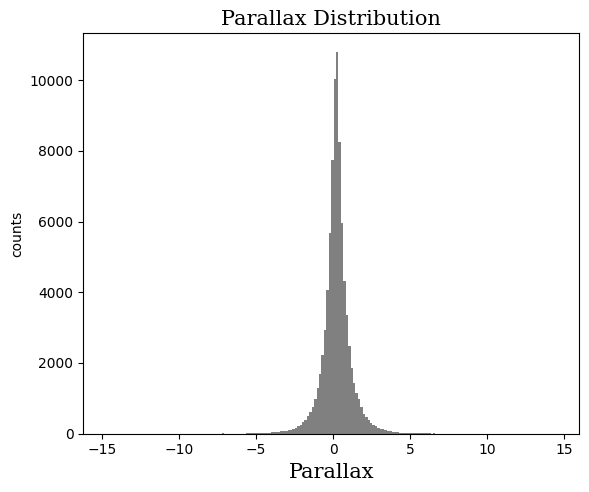

In [5]:
gplt.histogram(fas.parallax.value, xlabel='Parallax')

Removing poroper motion extreme outliers and creating a copy sample with only positive parallaxes

In [7]:
fas.apply_conditions(
    conditions={
        "pmra": ">-50",
        "pmdec":">-50",
    },
    inplace=True,
)
fas.apply_conditions(
    conditions={
        "pmra": "<50",
        "pmdec":"<50",
    },
    inplace=True,
)
pfas = fas.apply_conditions(
    conditions={
        'parallax': ">0"
    },
    inplace=False,
)

Cut 0.029% of the sample
Cut 0.082% of the sample


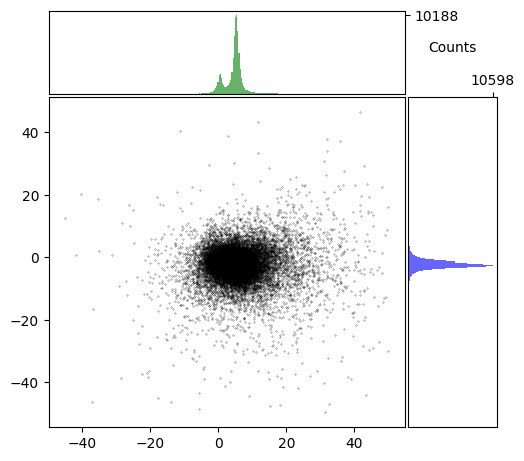

In [8]:
grasp.plots.doubleHistScatter(fas.pmra.value, fas.pmdec.value, size=0.05, alpha=0.85)

In [9]:
data = fas[['ra','dec','pmra','pmdec', 'parallax']].to_numpy()
pdata = pfas[['ra','dec','pmra','pmdec', 'parallax']].to_numpy()

### Single GMM

#### Model1: GMM with  $\,\forall \bar{\omega} \in \mathcal{R}$

Correctly imported `mclust`.
fitting ...
  |======================================================================| 100%
          ra        dec      pmra     pmdec  parallax
G1  6.019613 -72.081809  5.272867 -2.545650  0.204160
G2  6.820229 -72.273403  0.603810 -1.262448  0.015466
G3  6.103930 -72.106391  6.075893 -2.508344  0.397974
Correctly imported `mclust`.


Text(0.5, 1.0, 'Model1 Test Set')

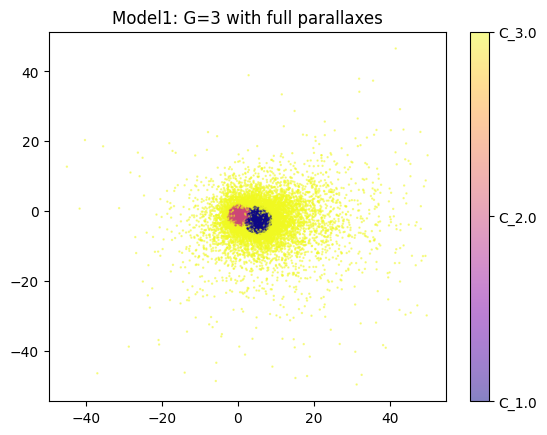

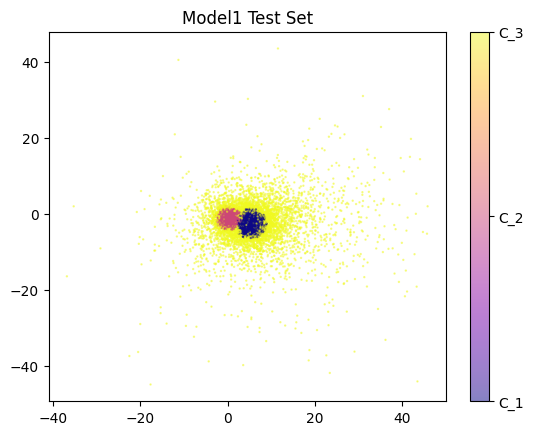

In [10]:
#```python

X_train, X_test = train_test_split(data, test_size=0.33)

model1 = grasp.stats.gaussian_mixture_model(train_data=X_train, G=3, modelNames=np.array(['VII', 'VVI']), verbose=True)

plt.figure()
plt.scatter(X_train[:,2], X_train[:,3], c=model1.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model1.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model1.train_classification['classification'])])
plt.title('Model1: G=3 with full parallaxes')

pd.DataFrame(data=model1.train_classification['classification']).value_counts()

model1_parameters = pd.DataFrame(data=model1.coeffs, index=['G1','G2','G3'], columns=['ra','dec','pmra','pmdec','parallax'])

print(model1_parameters)

predictions = model1.predict(X_test)

plt.figure()
plt.scatter(X_test[:,2], X_test[:,3], c=predictions['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions['classification'])])
plt.title('Model1 Test Set')

#```

#### Model2: GMM with $\,\forall\bar{\omega}\in\mathcal{R}^+$

Correctly imported `mclust`.
fitting ...
  |======================================================================| 100%
          ra        dec      pmra     pmdec  parallax
G1  6.407243 -72.175173  4.362864 -2.242788  1.008389
G2  6.011752 -72.082365  5.252787 -2.565782  0.333097
G3  6.030225 -72.079006  4.842803 -2.698683  0.952906
Correctly imported `mclust`.


Text(0.5, 1.0, 'Model2 Test Set')

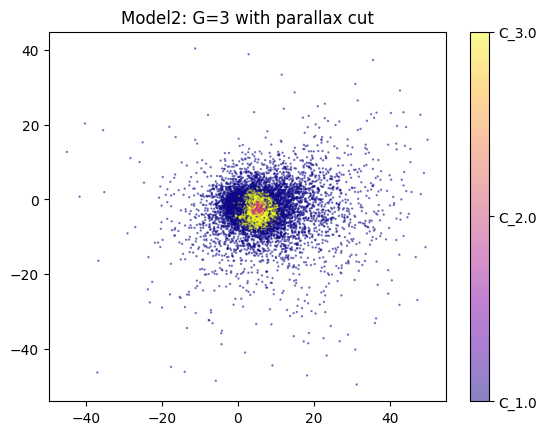

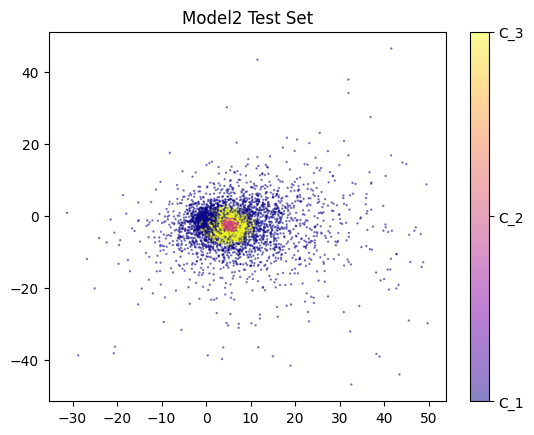

In [11]:
#```python
X_train2, X_test2 = train_test_split(pdata, test_size=0.33)
model2 = grasp.stats.gaussian_mixture_model(train_data=X_train2, G=3, modelNames=np.array(['VII', 'VVI']), verbose=True)

plt.figure()
plt.scatter(X_train2[:,2], X_train2[:,3], c=model2.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model2.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model2.train_classification['classification'])])
plt.title('Model2: G=3 with parallax cut')

pd.DataFrame(data=model2.train_classification['classification']).value_counts()
model2_parameters = pd.DataFrame(data=model2.coeffs, index=['G1','G2','G3'], columns=['ra','dec','pmra','pmdec','parallax'])
print(model2_parameters)
predictions2 = model2.predict(X_test2)

plt.figure()
plt.scatter(X_test2[:,2], X_test2[:,3], c=predictions2['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions2['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions2['classification'])])
plt.title('Model2 Test Set')
#```

#### Model3: $G=2$ with $\forall\bar{\omega}\in\mathcal{R}^+$

Correctly imported `mclust`.
fitting ...
  |======================================================================| 100%
Correctly imported `mclust`.
          ra        dec      pmra     pmdec  parallax
G1  6.327933 -72.155208  4.361715 -2.388903  1.077175
G2  6.010437 -72.082611  5.219715 -2.598208  0.440950


Text(0.5, 1.0, 'Model3 Test Set')

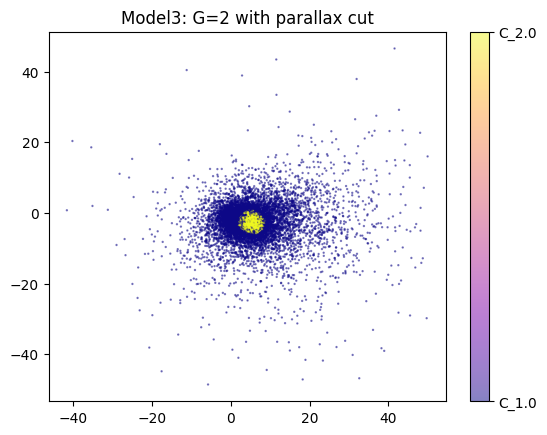

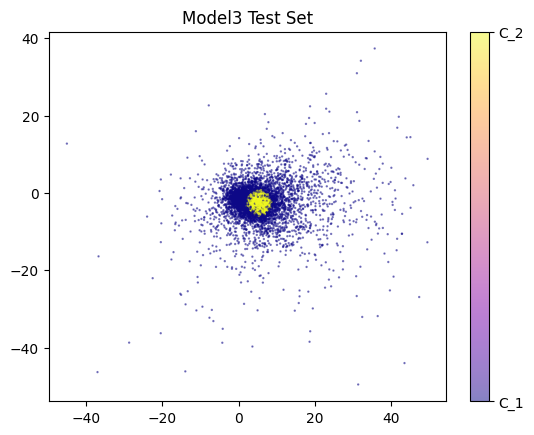

In [12]:
#```python
X_train2, X_test2 = train_test_split(pdata, test_size=0.33)
model3 = grasp.stats.gaussian_mixture_model(train_data=X_train2, G=2, modelNames=np.array(['VII', 'VVI']), verbose=True)


plt.figure()
plt.scatter(X_train2[:,2], X_train2[:,3], c=model3.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model3.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model3.train_classification['classification'])])
plt.title('Model3: G=2 with parallax cut')

pd.DataFrame(data=model3.train_classification['classification']).value_counts()
predictions3 = model3.predict(X_test2)
model3_parameters = pd.DataFrame(data=model3.coeffs, index=['G1','G2'], columns=['ra','dec','pmra','pmdec','parallax'])
print(model3_parameters)

plt.figure()
plt.scatter(X_test2[:,2], X_test2[:,3], c=predictions3['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions3['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions3['classification'])])
plt.title('Model3 Test Set')
#```

#### Model4: $G=2$ with $\forall\bar{\omega}\in\mathcal{R}$

Correctly imported `mclust`.
fitting ...
  |======================================================================| 100%
Correctly imported `mclust`.
          ra        dec      pmra     pmdec  parallax
G1  6.017153 -72.081380  5.268250 -2.548510  0.203455
G2  6.389423 -72.173335  3.874231 -1.996784  0.231260


Text(0.5, 1.0, 'Model3 Test Set')

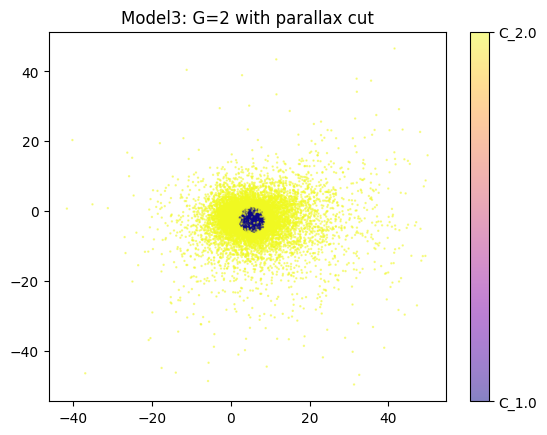

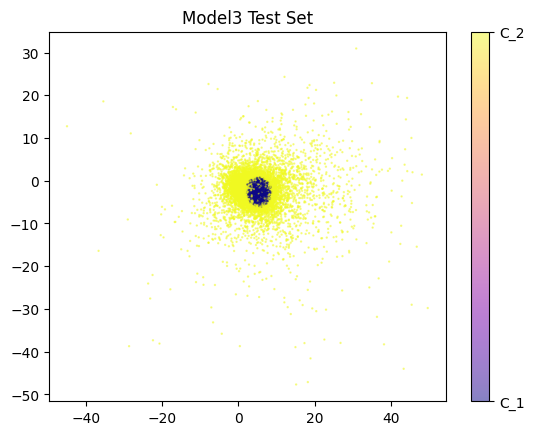

In [13]:
#```python
X_train, X_test = train_test_split(data, test_size=0.33)
model4 = grasp.stats.gaussian_mixture_model(train_data=X_train, G=2, modelNames=np.array(['VII', 'VVI']), verbose=True)

plt.figure()
plt.scatter(X_train[:,2], X_train[:,3], c=model4.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model4.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model4.train_classification['classification'])])
plt.title('Model3: G=2 with parallax cut')

pd.DataFrame(data=model4.train_classification['classification']).value_counts()
predictions4 = model4.predict(X_test)
model4_parameters = pd.DataFrame(data=model4.coeffs, index=['G1','G2'], columns=['ra','dec','pmra','pmdec','parallax'])
print(model4_parameters)

plt.figure()
plt.scatter(X_test[:,2], X_test[:,3], c=predictions4['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions4['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions4['classification'])])
plt.title('Model3 Test Set')
#```

### KFold Cross-Validation with GMM

#### G=3  -  $\forall\bar{\omega}\in\mathcal{R}^+$ 

In [14]:
nfolds = 20
kfm_3pos = grasp.stats.kfold_gmm_estimator(
    data=pdata,
    folds=nfolds,
    G=3,
    modelNames=np.array(['VII', 'VVI']),
    verbose=False
)

Correctly imported `mclust`.
[1] "Fold 1"
[1] "Fold 2"
[1] "Fold 3"
[1] "Fold 4"
[1] "Fold 5"
[1] "Fold 6"
[1] "Fold 7"
[1] "Fold 8"
[1] "Fold 9"
[1] "Fold 10"
[1] "Fold 11"
[1] "Fold 12"
[1] "Fold 13"
[1] "Fold 14"
[1] "Fold 15"
[1] "Fold 16"
[1] "Fold 17"
[1] "Fold 18"
[1] "Fold 19"
[1] "Fold 20"


Model's BIC Variance: 1.726 %


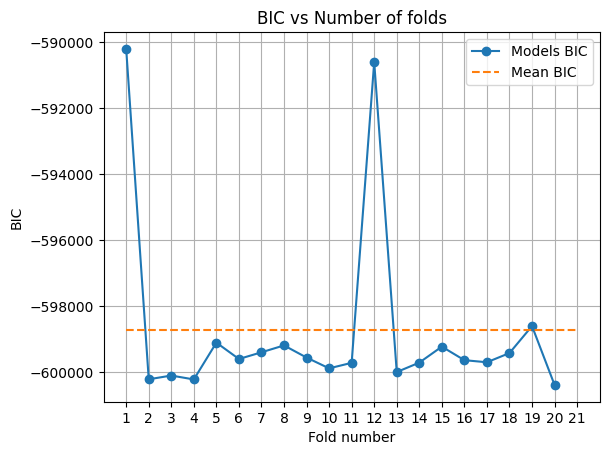

In [15]:
plt.plot(np.arange(1,nfolds+1), kfm_3pos.bics, '-o', label='Models BIC')
plt.plot([1,nfolds+1], [kfm_3pos.mean_bic,kfm_3pos.mean_bic], '--', label='Mean BIC')
plt.xticks(ticks=np.arange(1, nfolds + 2, 1))
plt.grid(True)
plt.title('BIC vs Number of folds')
plt.xlabel('Fold number')
plt.ylabel('BIC')
plt.legend(loc='best')

print(f"Model's BIC Variance: {(np.min(kfm_3pos.bics) - np.max(kfm_3pos.bics))/np.max(kfm_3pos.bics) * 100:.3f} %")

#### G=2  -  $\forall\bar{\omega}\in\mathcal{R}^+$ 

In [16]:
nfolds = 20
kfm_2pos = grasp.stats.kfold_gmm_estimator(
    data=pdata,
    folds=nfolds,
    G=2,
    modelNames=np.array(['VII', 'VVI']),
    verbose=False
)

Correctly imported `mclust`.
[1] "Fold 1"
[1] "Fold 2"
[1] "Fold 3"
[1] "Fold 4"
[1] "Fold 5"
[1] "Fold 6"
[1] "Fold 7"
[1] "Fold 8"
[1] "Fold 9"
[1] "Fold 10"
[1] "Fold 11"
[1] "Fold 12"
[1] "Fold 13"
[1] "Fold 14"
[1] "Fold 15"
[1] "Fold 16"
[1] "Fold 17"
[1] "Fold 18"
[1] "Fold 19"
[1] "Fold 20"


Model's BIC Variance: 0.299 %


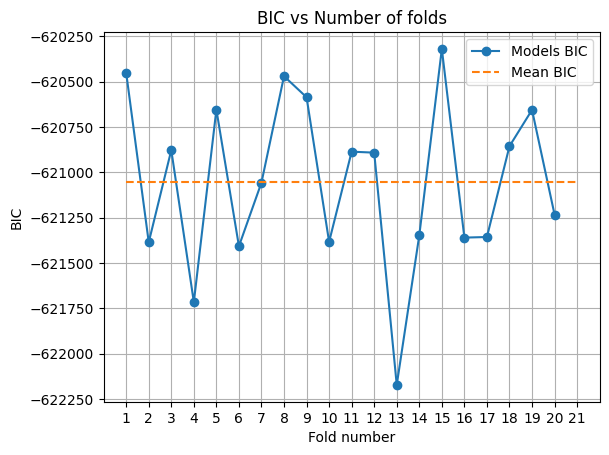

In [17]:
plt.plot(np.arange(1,nfolds+1), kfm_2pos.bics, '-o', label='Models BIC')
plt.plot([1,nfolds+1], [kfm_2pos.mean_bic,kfm_2pos.mean_bic], '--', label='Mean BIC')
plt.xticks(ticks=np.arange(1, nfolds + 2, 1))
plt.grid(True)
plt.title('BIC vs Number of folds')
plt.xlabel('Fold number')
plt.ylabel('BIC')
plt.legend(loc='best')

print(f"Model's BIC Variance: {(np.min(kfm_2pos.bics) - np.max(kfm_2pos.bics))/np.max(kfm_2pos.bics) * 100:.3f} %")

#### G=3  -  $\forall\bar{\omega}\in\mathcal{R}$

In [18]:
nfolds = 20
kfm_3 = grasp.stats.kfold_gmm_estimator(
    data=data,
    folds=nfolds,
    G=3,
    modelNames=np.array(['VII', 'VVI']),
    verbose=False
)

Correctly imported `mclust`.
[1] "Fold 1"
[1] "Fold 2"
[1] "Fold 3"
[1] "Fold 4"
[1] "Fold 5"
[1] "Fold 6"
[1] "Fold 7"
[1] "Fold 8"
[1] "Fold 9"
[1] "Fold 10"
[1] "Fold 11"
[1] "Fold 12"
[1] "Fold 13"
[1] "Fold 14"
[1] "Fold 15"
[1] "Fold 16"
[1] "Fold 17"
[1] "Fold 18"
[1] "Fold 19"
[1] "Fold 20"


Model's BIC Variance: 2.487 %


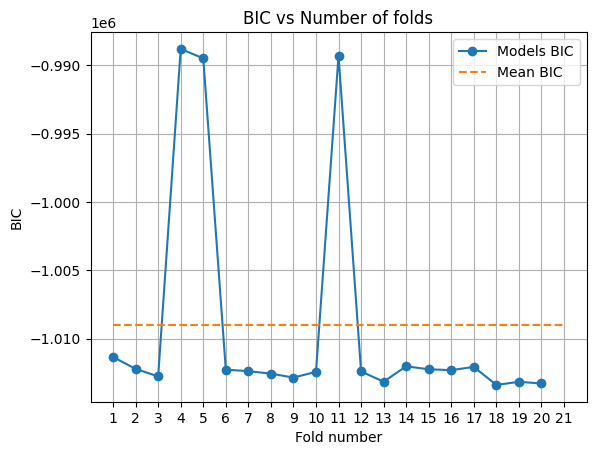

In [19]:
plt.plot(np.arange(1,nfolds+1), kfm_3.bics, '-o', label='Models BIC')
plt.plot([1,nfolds+1], [kfm_3.mean_bic,kfm_3.mean_bic], '--', label='Mean BIC')
plt.xticks(ticks=np.arange(1, nfolds + 2, 1))
plt.grid(True)
plt.title('BIC vs Number of folds')
plt.xlabel('Fold number')
plt.ylabel('BIC')
plt.legend(loc='best')

print(f"Model's BIC Variance: {(np.min(kfm_3.bics) - np.max(kfm_3.bics))/np.max(kfm_3.bics) * 100:.3f} %")

#### G=2  -  $\forall\bar{\omega}\in\mathcal{R}$

In [25]:
nfolds = 20
kfm_2 = grasp.stats.kfold_gmm_estimator(
    data=data,
    folds=nfolds,
    G=2,
    modelNames=np.array(['VII', 'VVI']),
    verbose=False
)

Correctly imported `mclust`.
[1] "Fold 1"
[1] "Fold 2"
[1] "Fold 3"
[1] "Fold 4"
[1] "Fold 5"
[1] "Fold 6"
[1] "Fold 7"
[1] "Fold 8"
[1] "Fold 9"
[1] "Fold 10"
[1] "Fold 11"
[1] "Fold 12"
[1] "Fold 13"
[1] "Fold 14"
[1] "Fold 15"
[1] "Fold 16"
[1] "Fold 17"
[1] "Fold 18"
[1] "Fold 19"
[1] "Fold 20"


Model's BIC Variance: 0.141 %


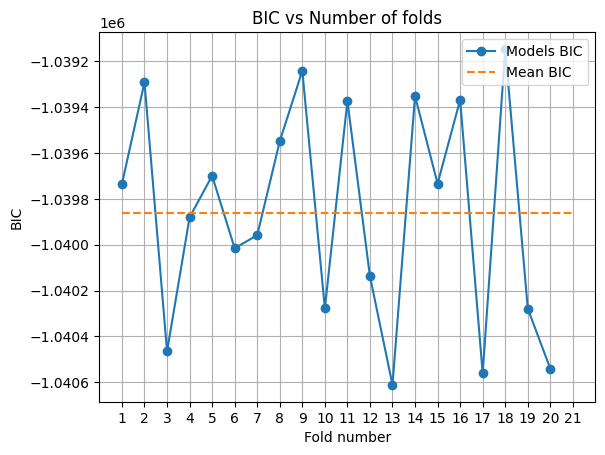

In [26]:
plt.plot(np.arange(1,nfolds+1), kfm_2.bics, '-o', label='Models BIC')
plt.plot([1,nfolds+1], [kfm_2.mean_bic,kfm_2.mean_bic], '--', label='Mean BIC')
plt.xticks(ticks=np.arange(1, nfolds + 2, 1))
plt.grid(True)
plt.title('BIC vs Number of folds')
plt.xlabel('Fold number')
plt.ylabel('BIC')
plt.legend(loc='best')

print(f"Model's BIC Variance: {(np.min(kfm_2.bics) - np.max(kfm_2.bics))/np.max(kfm_2.bics) * 100:.3f} %")

#### Best Model Selection

In [27]:
best_models = {
    'G=3 pos': kfm_3pos.best_model(),
    'G=2 pos': kfm_2pos.best_model(),
    'G=3': kfm_3.best_model(),
    'G=2': kfm_2.best_model()
}

In [28]:
print(f"Best G=3 w>0 Model:\n {pd.DataFrame(best_models['G=3 pos'].coeffs, columns=['ra','dec','pmra','pmdec','parallax'])}\n")
print(f"Best G=2 w>0 Model:\n{pd.DataFrame(best_models['G=2 pos'].coeffs, columns=['ra','dec','pmra','pmdec','parallax'])}\n")
print(f"Best G=3 Model:\n{pd.DataFrame(best_models['G=3'].coeffs, columns=['ra','dec','pmra','pmdec','parallax'])}\n")
print(f"Best G=2 Model:\n{pd.DataFrame(best_models['G=2'].coeffs, columns=['ra','dec','pmra','pmdec','parallax'])}")

Best G=3 w>0 Model:
          ra        dec      pmra     pmdec  parallax
0  6.029361 -72.080389  4.880941 -2.683017  0.919155
1  6.415810 -72.174183  4.385810 -2.271032  1.025941
2  6.007249 -72.083236  5.254873 -2.568132  0.323284

Best G=2 w>0 Model:
         ra        dec      pmra     pmdec  parallax
0  6.013411 -72.082341  5.220823 -2.595929  0.443069
1  6.328213 -72.154740  4.383672 -2.364966  1.072658

Best G=3 Model:
         ra        dec      pmra     pmdec  parallax
0  6.011254 -72.081508  5.269594 -2.554346  0.207337
1  6.501465 -72.199530  3.608957 -1.905596  0.267687
2  6.039430 -72.080654  5.028780 -2.437439  0.164891

Best G=2 Model:
         ra        dec      pmra     pmdec  parallax
0  6.016667 -72.081485  5.267913 -2.548581  0.204641
1  6.397007 -72.171687  3.862631 -1.991974  0.235474


In [30]:
for key,value in best_models.items():
    best_models[key].save_model(grasp.gpaths.CLUSTER_DATA_FOLDER(gc.id)+f'/{key}')
    print(f"{key} model saved\n")

Model saved to /home/pietrof/graspdata/query/NGC104/G=3 pos.rds
G=3 pos model saved

Model saved to /home/pietrof/graspdata/query/NGC104/G=2 pos.rds
G=2 pos model saved

Model saved to /home/pietrof/graspdata/query/NGC104/G=3.rds
G=3 model saved

Model saved to /home/pietrof/graspdata/query/NGC104/G=2.rds
G=2 model saved



### Try the predict on the Golden Sample

In [ ]:
aps.drop_columns(
    [
        "radial_velocity",
        "radial_velocity_error",
        "bp_rp",
        "phot_g_mean_mag",
        "teff_gspphot",
        "phot_bp_mean_mag",
        "phot_rp_mean_mag",
        "phot_bp_rp_excess_factor"
    ]
)
aps.info()

In [ ]:
gs_data = aps.to_numpy(columns=['ra','dec','pmra','pmdec', 'parallax'])
text = []
for name, model in best_models.items():
    _ = best_models[name].predict(gs_data)
    print(f"Predicting with {name} model...\n")

In [ ]:
headers = ['G_KDE', 'XDGMM', 'GMM (G=3 w>0)', 'GMM (G=2 w>0)', 'GMM (G=3)', 'GMM (G=2)']
showindex = ['pmra', 'pmdec', 'parallax']

pmras = [pmra_mean, xdgmm_pmra_mean, best_models['G=3 pos'].coeffs[2,2], best_models['G=2 pos'].coeffs[1,2], best_models['G=3'].coeffs[2,2], best_models['G=2'].coeffs[0,2]]
pmdecs = [pmdec_mean, xdgmm_pmdec_mean, best_models['G=3 pos'].coeffs[2,3], best_models['G=2 pos'].coeffs[1,3], best_models['G=3'].coeffs[2,3], best_models['G=2'].coeffs[0,3]]
parallaxes = [best_models['G=3 pos'].coeffs[2,4], best_models['G=2 pos'].coeffs[1,4], best_models['G=3'].coeffs[2,4], best_models['G=2'].coeffs[0,4]]

print(tabulate.tabulate([pmras, pmdecs, parallaxes], headers=headers, showindex=showindex, tablefmt='latex_raw'))

print("Proper Motions RA")
print(f"{'kde':<10} {'xdgmm':<10} {'G=3 w>0':<10} {'G=2 w>0':<10} {'G=3':<10} {'G=2':<10}")
print(f"{pmra_mean:<10.3f} {xdgmm_pmra_mean:<10.3f} {best_models['G=3 pos'].coeffs[2,2]:<10.3f} {best_models['G=2 pos'].coeffs[1,2]:<10.3f} {best_models['G=3'].coeffs[2,2]:<10.3f} {best_models['G=2'].coeffs[0,2]:<10.3f}\n")

print("Proper Motions DEC")
print(f"{'kde':<10} {'xdgmm':<10} {'G=3 w>0':<10} {'G=2 w>0':<10} {'G=3':<10} {'G=2':<10}")
print(f"{pmdec_mean:<10.3f} {xdgmm_pmdec_mean:<10.3f} {best_models['G=3 pos'].coeffs[2,3]:<10.3f} {best_models['G=2 pos'].coeffs[1,3]:<10.3f} {best_models['G=3'].coeffs[2,3]:<10.3f} {best_models['G=2'].coeffs[0,3]:<10.3f}\n")

print("Parallax")
print(f"{'G=3 w>0':<10} {'G=2 w>0':<10} {'G=3':<10} {'G=2':<10}")
print(f"{best_models['G=3 pos'].coeffs[2,4]:<10.3f} {best_models['G=2 pos'].coeffs[1,4]:<10.3f} {best_models['G=3'].coeffs[2,4]:<10.3f} {best_models['G=2'].coeffs[0,4]:<10.3f}\n")

In [ ]:
pmraaa = grasp.stats.bootstrap_statistic(pmras, np.mean, 4)
pmdeec = grasp.stats.bootstrap_statistic(pmdecs, np.mean, 4)
parallaxaa = grasp.stats.bootstrap_statistic(parallaxes, np.mean, 4)

In [ ]:
pmra     = -12.518 $\pm$ 0.004
pmdec    = -19.018 $\pm$ 0.003
parallax = 0.539 $\pm$ 0.005

In [ ]:
print(f"{'pmra':<8} = {pmraaa[0]:.3f} $\\pm$ {pmraaa[1]:.3f}")
print(f"{'pmdec':<8} = {pmdeec[0]:.3f} $\\pm$ {pmdeec[1]:.3f}")
print(f"{'parallax':<8} = {parallaxaa[0]:.3f} $\\pm$ {parallaxaa[1]:.3f}")

# Effective Potential Computation

### Loading the model and computing all the quantities

In [ ]:
names = ['G=3 pos','G=2 pos','G=3','G=2']
best_models = {}
for n in names:
   best_models[n] =  grasp.GaussianMixtureModel.load_model(
    grasp.gpaths.CLUSTER_DATA_FOLDER(gc.id)+f'/{n}'
)

Utilizzando quaattro metodi diversi, si è calcolato il valore medio dei parametri per il cluster:

La media è stata calcolata con la formula classica, mentre l'uncertainty è stata stimata come $\epsilon = \dfrac{\sigma}{\sqrt{N}}$

$$ \langle\bar{\omega}\rangle = 0.550 \pm 0.002 \, \mathrm{mas} \rightarrow \sim 1.81 \,\mathrm{kpc}$$ 

$$ \langle\mu_\alpha\rangle = -12.528 \pm 0.003 \, \mathrm{mas\cdot yr}^{-1}$$

$$ \langle\mu_{\delta^*}\rangle = -19.022 \pm 0.005 \, \mathrm{mas\cdot yr}^{-1}$$


## Model with G=3 $\forall \bar{\omega}\in\mathcal{R}$

### Data Computation

In [ ]:
best_model = best_models['G=3']
print(pd.DataFrame(best_model.train_classification['classification']).value_counts())
print(best_model.coeffs)

In [ ]:
model_data = best_model.data
gs_data = aps.to_numpy(columns=['ra','dec','pmra','pmdec', 'parallax'])
_ = best_model.predict(gs_data)

gc.ra, gc.dec = (best_model.coeffs[2,0], best_model.coeffs[2,1])
print(gc.ra, gc.dec)

In [ ]:
# mu_ra = np.array([np.mean(pmrameans), np.std(pmrameans)/np.sqrt(len(pmrameans))])
# mu_dec = np.array([np.mean(pmdecmeans), np.std(pmdecmeans)/np.sqrt(len(pmdecmeans))])
# px = np.array([np.mean(parallaxmeans), np.std(parallaxmeans)/np.sqrt(len(parallaxmeans))])

# Se si riparte direttamente da qui...
mu_ra = (-12.528 ,0.003)
mu_dec = (-19.022 ,0.005)
px = (0.550 ,0.002)

gc.px = (px[0] * u.mas, px[1] * u.mas)
gc.pmra = (mu_ra[0] * u.mas / u.yr, mu_ra[1] * u.mas / u.yr)
gc.pmdec = (mu_dec[0] * u.mas / u.yr, mu_dec[1] * u.mas / u.yr)

gc_data = model_data[np.array(best_model.train_classification['classification']) == 3.]
gc2_data = gs_data[np.array(best_model.classification['classification']) == 3.]
print(f"{gc_data.shape = } {gc2_data.shape = }")

predicted_sample = np.vstack((gc_data, gc2_data))

assert len(predicted_sample) == len(gc_data) + len(gc2_data), f"Predicted sample length {len(predicted_sample)} is not equal to the sum of gc_data {len(gc_data)} and gs_data {len(gc2_data)}"

print(f"\n{predicted_sample.shape = }")

In [ ]:
gc_data = pd.DataFrame(data=predicted_sample, columns=['ra','dec','pmra','pmdec', 'parallax'])
gc_sample = grasp.Sample(gc_data, gc)
gc_sample.update_gc_params(ra=gc_sample.ra.mean(), dec=gc_sample.dec.mean())

In [ ]:
grasp.plots.seaborn(which='heatmap', data=gc_sample.to_pandas().corr(), annot=True, cmap='coolwarm', cbar=True)

In [ ]:
ff = grasp.load_base_formulary()
ff.substitute(
    "Angular separation",
    {"alpha_{0}": (gc_sample.gc.ra*u.deg).to(u.rad).value, "delta_{0}": (gc_sample.gc.dec*u.deg).to(u.rad).value}
)
ff.angular_separation

In [ ]:
gc_sample.apply_conditions('parallax>0.05', inplace=True)
N=len(gc_sample)

### Calcolo delle distance: $r_{2D}$ and  $R_{3D}$

In [ ]:
gc_sample['ang_sep']        = (ff.compute("Angular Separation", data={"alpha_{1}": (gc_sample.ra*u.deg).to(u.rad).value, "delta_{1}": (gc_sample.dec*u.deg).to(u.rad).value}, asarray=True)) * u.deg
gc_sample['los_distance']   = (ff.compute('los_distance', data={'omega': gc_sample.parallax.value}, asarray=True)) * u.kpc
gc_sample['d_BV']           = (ff.compute('gc_z_coordinate', data={r'r_{c}': [gc_sample.gc.dist.value/1000]*N, r'r_{x}': gc_sample.los_distance.value}, asarray=True))  * u.kpc 
gc_sample['d']              = (ff.compute('gc_z_coordinate', data={r'r_{c}': [1/gc_sample.gc.px[0].value]*N, r'r_{x}': gc_sample.los_distance.value}, asarray=True)) * u.kpc
gc_sample['r2d_BV']         = (ff.compute('radial_distance_2d', data={r'r_{c}': [gc_sample.gc.dist.value/1000]*N, 'theta': gc_sample.ang_sep.to(u.rad).value}, asarray=True)) * u.kpc
gc_sample['r2d']            = (ff.compute('radial_distance_2d', data={r'r_{c}': [1/gc_sample.gc.px[0].value]*N, 'theta': gc_sample.ang_sep.to(u.rad).value}, asarray=True)) * u.kpc
gc_sample['r3d_BV']         = (ff.compute('radial_distance_3d', data={'d': gc_sample.d_BV.to(u.pc).value, 'r_{2}': gc_sample.r2d_BV.to(u.pc).value}, asarray=True)) * u.pc
gc_sample['r3d']            = (ff.compute('radial_distance_3d', data={'d': gc_sample.d.to(u.pc).value, 'r_{2}': gc_sample.r2d.to(u.pc).value}, asarray=True)) * u.pc

In [ ]:
gc_sample['ra'] = gc_sample.ra * (u.deg)
gc_sample['dec'] = gc_sample.dec * (u.deg)
gc_sample['pmra'] = gc_sample.pmra * (u.mas / u.yr)
gc_sample['pmdec'] = gc_sample.pmdec * (u.mas / u.yr)
gc_sample['parallax'] = gc_sample.parallax * (u.mas)

In [ ]:
gc_sample['los_distance'] = gc_sample.r2d_BV.to(u.pc)
gc_sample['d_BV'] = gc_sample.r2d.to(u.pc)
gc_sample['d'] = gc_sample.r2d.to(u.pc)
gc_sample['r2d_BV'] = gc_sample.r2d_BV.to(u.pc)
gc_sample['r2d'] = gc_sample.r2d.to(u.pc)

In [ ]:
gc_sample.apply_conditions('r3d<4000', inplace=True)
grasp.plots.histogram(gc_sample.r3d.value, xlabel=r"$R_{3D}$")

### Density (WOW, bad!)

In [ ]:
r3dh = grasp.plots.histogram(gc_sample.r3d.value, dont_show=True)

n_bin = len(r3dh['h']['bins'])

V = np.zeros(n_bin)
rr1 = np.zeros(n_bin+1)
rr2 = np.zeros(n_bin+1)

bw = (gc_sample.r3d.value).max()/n_bin

rr1[0] = 0.
rr2[0] = bw

for x in range (0, n_bin):
  V[x] = (4/3)*np.pi*(rr2[x]**3 - rr1[x]**3)
  rr1[x+1] = rr1[x] + bw
  rr2[x+1] = rr2[x] + bw

rho3D = r3dh['h']['counts']/(V*u.pc**3)  

In [ ]:
r_c = (1/gc_sample.gc.px[0].value*1000) * np.tan(gc_sample.gc.rc.to(u.rad).value)

In [ ]:
plt.plot(gc_sample.gc.model['xi'], gc_sample.gc.model['rho'], '--', c='red', label='SM King Model')
plt.plot(((rr1[0:n_bin]+rr2[0:n_bin])/2)/r_c, rho3D.value, '-o', markersize=2, c='blue', label='Observed Density')
plt.xscale('log')
plt.yscale('log')

### Setting up the velocities

In [ ]:
gc_sample['pmra'].unit

In [ ]:
grasp.plots.histogram(gc_sample.pmra.value)

In [ ]:
gc_sample['v_x'] = ((gc_sample.pmra  - gc_sample.gc.pmra[0] ).to(u.rad/u.s) * (1/gc_sample.gc.px[0] * (u.kpc*u.mas)).to(u.km)) / u.rad 
gc_sample['v_y'] = ((gc_sample.pmdec - gc_sample.gc.pmdec[0]).to(u.rad/u.s) * (1/gc_sample.gc.px[0] * (u.kpc*u.mas)).to(u.km)) / u.rad

In [ ]:
vx_med, vx_med_err = grasp.stats.bootstrap_statistic(gc_sample.v_x.value**2, np.median, n_bootstrap=5000, show_progress=True)
vy_med, vy_med_err = grasp.stats.bootstrap_statistic(gc_sample.v_y.value**2, np.median, n_bootstrap=5000, show_progress=True)

vxm, vxm_err = grasp.stats.bootstrap_statistic(gc_sample.v_x.value**2, np.average, n_bootstrap=5000, show_progress=True)
vym, vym_err = grasp.stats.bootstrap_statistic(gc_sample.v_y.value**2, np.average, n_bootstrap=5000, show_progress=True)


In [ ]:
grasp.plots.doubleHistScatter(gc_sample['v_x'].value, gc_sample['v_y'].value, xlabel=r"$v_x$ [km/s]", ylabel=r'$v_y$ [km/s]',size=0.05, alpha=0.85)

In [ ]:
grasp.plots.histogram(
    gc_sample['v_y'].value**2, 
    xlabel=r'$v_y^2 \, [km^2\,s^{-2}]$', title=r'$<v_y^2> = ${:.2f} $\pm$ {:.2f}    Median($v_y^2$)={:.2f} $\pm$ {:.2F}'.format(
        vxm, vym_err,
        vy_med, vy_med_err
        )
    )

In [ ]:
grasp.plots.histogram(
    gc_sample['v_x'].value**2, 
    xlabel=r"$v_x^2 \, [km^2\,s^{-2}]$", title=r'$<v_x^2> = ${:.2f} $\pm$ {:.2f}    Median($v_x^2$)={:.2f} $\pm$ {:.2f}'.format(
        vxm, vxm_err,
        vx_med, vx_med_err
        )
    )

On Isotropy assumption, compute the total (squared) velocity as:

$$ V^2 = \frac{3}{2}(v_x^2 + v_y^2)^2

In [ ]:
gc_sample['v2'] = 1.5*(gc_sample['v_x']**2 + gc_sample['v_y']**2) 
v2m, v2m_err = grasp.stats.bootstrap_statistic(gc_sample.v2.value, np.average, n_bootstrap=5000, show_progress=True)
v2_med, v2_med_err = grasp.stats.bootstrap_statistic(gc_sample.v2.value, np.median, n_bootstrap=5000, show_progress=True)
v2h = grasp.plots.histogram(
    gc_sample['v2'].value, 
    xlabel=r"$v^2 \, [km^2\,s^{-2}]$", title=r'$<v^2> = ${:.2f} $\pm$ {:.2f}    Median($v^2$)={:.2f} $\pm$ {:.2f}'.format(
        v2m, v2m_err,
        v2_med, v2_med_err
        ),
    out=True
    )

### Shell Partition

In [ ]:
# Desired number of instances per subsample
n_per_shell = 250  # for example

# Sort by r3d
sorted_sample = gc_sample.to_pandas().sort_values('r3d')

# Split into equal-length subsamples
shell_samples = [
    sorted_sample.iloc[i:i + n_per_shell]
    for i in range(0, len(sorted_sample), n_per_shell)
]

# Optionally, filter out the last shell if it's too small
shell_samples = [s for s in shell_samples if len(s) == n_per_shell]

print(f"Number of shells: {len(shell_samples)}")

In [ ]:
v2 = grasp.types.QTable()
R  = grasp.types.QTable()

for i,shell in enumerate(shell_samples):
    
    R[f"s{i}"] = shell['r3d']
    v2[f"s{i}"] = shell['v2']

v2 = grasp.Sample(v2, gc)
R = grasp.Sample(R, gc)

In [ ]:
v2h = []
for i in range(len(shell_samples)):
    v2h.append(grasp.plots.histogram(v2[f's{i}'], xlabel='$v^2$', title=f'Shell {i} - R_max={R[f"s{i}"].max():.3f} - R_width = {R[f"s{i}"].max() - R[f"s{i}"].min():.3f}', dont_show=True))

### $B = 16 A \sqrt{2} \pi^2 \beta^2 r_{s}^2 \alpha m^3 \sigma^3 dr dx$

#### Constants:

> Normalization constant: $A = 1$

> Single star Mass: $m = 1$

> Incompleteness parameter: $\alpha = 10^{-3}$


In [ ]:
A = 1.
alpha = .001
m = 1.

ff.substitute('B constant', 
              {
                  'A': A,
                  'alpha': alpha,
                  'm': m
              }
)

In [ ]:
ff.b_constant

#### $\sigma^2$ : critical velocity 

It is taken to be the maximum quadratic velocity of the shell $v^2\{shell\}^{max}$. <br>
It's the memory of the Maxwellian velocity distribution of the system.

In [ ]:
sigmas = []
for i,s in enumerate(shell_samples):
    sigmas.append(np.sqrt(s.v2.max()))

sigmas = np.array(sigmas)

In [ ]:
plt.plot(sigmas, '--o', markersize=3, c='blue')

#### $\beta$ & $r_s$
 $\beta$ : Estimation from bootstrap statistics on shell<br>
Its the uncertainty parameter on the distance of the shell from the centre of the GC. <br>
This parameter could be estimated by computing the uncertainty of the median <br>
(not the mean, as outliers could heavily affect the result) of the $R_{3D}$ distances of <br>
the stars of the shell from the centre

$r_s$ : Median distance from the centre

In [ ]:
betas = []
rss = []

for i, s in enumerate(shell_samples):
    r, b = grasp.stats.bootstrap_statistic(
        s['r3d'],
        np.median,
        n_bootstrap=100,
        show_progress=False
    )
    betas.append(b)
    rss.append(r)

    
betas = np.array(betas)
rss = np.array(rss)

In [ ]:
plt.plot(rss, betas, '--o', markersize=3, c='blue')

#### $N$ , $x$

In [ ]:
Ns = []
x = []

for i, v in enumerate(v2h):
    Ns.append(v['h']['counts'])
    x.append(v['h']['bins']/(2*sigmas[i]**2))


#### $dx$ and $dr$

In [ ]:
dr = []
dx = []

for i, s in enumerate(shell_samples):
    dr.append(s.r3d.max() - s.r3d.min())
    dx.append(v2h[i]['h']['bins'][1] - v2h[i]['h']['bins'][0])

### $\Sigma = \ln{B} - x - \ln{\frac{\Delta_N}{\sqrt{x}}}$

In [ ]:
def Sigma(
    B: float,
    n: int = None,
    fit: grasp.types.Optional[grasp.types.RegressionModels] = None
) -> tuple[grasp.types.ArrayLike, grasp.types.ArrayLike]:
    """Computes analythical sigma"""
    xi = np.linspace(0, 0.5, 1000)
    if fit:
        #xi = np.linspace(0, 0.5, len(fit.x))
        A, l = fit.coeffs
        n = A* np.exp(l * xi)
    elif n is None:
        raise ValueError("Either n or alpha must be provided.")
    return (xi, np.log(B) - np.log(n / xi**0.5) - xi)

In [ ]:
import grasp.analyzers
import grasp.analyzers.calculus

poteffs = []
Bs = []

for i in range(len(shell_samples)):
    B = float(grasp.analyzers.calculus._sp.N(ff.b_constant.rhs.subs(
        {
            'r_{s}': rss[i],
            'sigma': sigmas[i],
            'dr': dr[i],
            'dx': dx[i],
            'beta' : betas[i],
            'pi': np.pi
        }
    )))
    Bs.append(B)
    poteffs.append(
        np.log(B) - x[i] - np.log(Ns[i] / x[i]**0.5)
    )


In [ ]:
def plot_poteff(n_shell: int):
    """Plot the effective potential for a given shell or list of shells."""
    fit = grasp.stats.fit_data_points(Ns[n_shell], x_data=x[n_shell], method='exponential')

    fig, ax = plt.subplots(figsize=(8,6.5))
    ax.plot(x[n_shell], poteffs[n_shell], 'o', markersize=4, c='black')
    xi, S = Sigma(Bs[n_shell], fit=fit)
    ax.plot(xi, S, '-', markersize=3, c='red')
    ax.set_ylabel(r'$\Phi_{eff}$', fontdict=grasp.plots.label_font)
    ax.set_xlabel(r'$x$', fontdict=grasp.plots.label_font)
    ax.set_title(f'Shell {n_shell} at ~{rss[n_shell]:.3f} pc', fontdict=grasp.plots.title_font)
    ax.set_xlim((-0.01, 0.51))

    return fig

folder = grasp.gpaths.CLUSTER_DATA_FOLDER(gc_sample.gc.id) + '/poteff_plots/model1'
if not os.path.exists(folder):
    os.makedirs(folder)
for i in range(len(shell_samples)):
    fig = plot_poteff(i)
    fig.savefig(f'{folder}/poteff_shell_{i}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)



In [ ]:
scarti_finali = []
for i in range(len(poteffs)):
    fit = grasp.stats.fit_data_points(Ns[i], x_data=x[i], method='exponential')
    xi, S = Sigma(Bs[i], fit=fit)

    scarti_finali.append(1-poteffs[i][-1]/S[-1])

scarti_finali = np.array(scarti_finali)

avg_underestimation = grasp.stats.bootstrap_statistic(scarti_finali, np.mean)
fig = plt.figure()
plt.plot(scarti_finali, 'o', markersize=3, c='blue')
plt.xlabel('Shell number', fontdict=grasp.plots.label_font)
plt.title(f"Average Underestimation = {avg_underestimation[0]*100 :.2f} +- {avg_underestimation[1]*100:.2f} %")
fig.savefig(
    grasp.gpaths.CLUSTER_DATA_FOLDER(gc_sample.gc.id) + '/poteff_plots/model3/scarti_finali.png',
    dpi=300, bbox_inches='tight'
)

In [ ]:
avg_underestimation = grasp.stats.bootstrap_statistic(scarti_finali, np.mean)

print(f"{avg_underestimation[0]*100 :.2f} +- {avg_underestimation[1]*100:.2f} %")

The average underestimation of the critical velocioty $x=0.5 \rightarrow \sigma^2 = 2\cdot v^2_{max}$ 
is 
> $15,97 \pm  1,08$ %

### $\Sigma = -\ln{1-e^{x-w}}$

In [ ]:
dpoteffs = []
Omega = []
s = gc_sample.v2.max()


for i,p in enumerate(poteffs):
    w = np.max(0.5*v2h[i]['h']['bins']/s)
    ssigma = -np.log(1 - np.exp(x[i] - 0.5))
    omega = ssigma - np.array(x[i])
    dpoteffs.append(ssigma)
    Omega.append(omega)



In [ ]:
for i in range(10):
    plt.plot(dpoteffs[i], '-o', markersize=3, label=f'Shell {i}', alpha=0.5)

plt.legend(loc='best')

## Model with G=2 $\forall \bar{\omega}\in\mathcal{R}$

### Data Computation

In [ ]:
best_model = best_models['G=2']
print(pd.DataFrame(best_model.train_classification['classification']).value_counts())
print(best_model.coeffs)

In [ ]:
model_data = best_model.data
gs_data = aps.to_numpy(columns=['ra','dec','pmra','pmdec', 'parallax'])
_ = best_model.predict(gs_data)

gc.ra, gc.dec = (best_model.coeffs[2,0], best_model.coeffs[2,1])
print(gc.ra, gc.dec)

In [ ]:
# mu_ra = np.array([np.mean(pmrameans), np.std(pmrameans)/np.sqrt(len(pmrameans))])
# mu_dec = np.array([np.mean(pmdecmeans), np.std(pmdecmeans)/np.sqrt(len(pmdecmeans))])
# px = np.array([np.mean(parallaxmeans), np.std(parallaxmeans)/np.sqrt(len(parallaxmeans))])

# Se si riparte direttamente da qui...
mu_ra = (-12.528 ,0.003)
mu_dec = (-19.022 ,0.005)
px = (0.550 ,0.002)

gc.px = (px[0] * u.mas, px[1] * u.mas)
gc.pmra = (mu_ra[0] * u.mas / u.yr, mu_ra[1] * u.mas / u.yr)
gc.pmdec = (mu_dec[0] * u.mas / u.yr, mu_dec[1] * u.mas / u.yr)

gc_data = model_data[np.array(best_model.train_classification['classification']) == 3.]
gc2_data = gs_data[np.array(best_model.classification['classification']) == 3.]
print(f"{gc_data.shape = } {gc2_data.shape = }")

predicted_sample = np.vstack((gc_data, gc2_data))

assert len(predicted_sample) == len(gc_data) + len(gc2_data), f"Predicted sample length {len(predicted_sample)} is not equal to the sum of gc_data {len(gc_data)} and gs_data {len(gc2_data)}"

print(f"\n{predicted_sample.shape = }")

In [ ]:
gc_data = pd.DataFrame(data=predicted_sample, columns=['ra','dec','pmra','pmdec', 'parallax'])
gc_sample = grasp.Sample(gc_data, gc)
gc_sample.update_gc_params(ra=gc_sample.ra.mean(), dec=gc_sample.dec.mean())

In [ ]:
grasp.plots.seaborn(which='heatmap', data=gc_sample.to_pandas().corr(), annot=True, cmap='coolwarm', cbar=True)

In [ ]:
ff = grasp.load_base_formulary()
ff.substitute(
    "Angular separation",
    {"alpha_{0}": (gc_sample.gc.ra*u.deg).to(u.rad).value, "delta_{0}": (gc_sample.gc.dec*u.deg).to(u.rad).value}
)
ff.angular_separation

In [ ]:
gc_sample.reset_sample()

In [ ]:
gc_sample.apply_conditions('parallax>0.05', inplace=True)
N=len(gc_sample)

### Calcolo delle distance: $r_{2D}$ and  $R_{3D}$

In [ ]:
gc_sample['ang_sep']        = (ff.compute("Angular Separation", data={"alpha_{1}": (gc_sample.ra*u.deg).to(u.rad).value, "delta_{1}": (gc_sample.dec*u.deg).to(u.rad).value}, asarray=True)) * u.deg
gc_sample['los_distance']   = (ff.compute('los_distance', data={'omega': gc_sample.parallax.value}, asarray=True)) * u.kpc
gc_sample['d_BV']           = (ff.compute('gc_z_coordinate', data={r'r_{c}': [gc_sample.gc.dist.value/1000]*N, r'r_{x}': gc_sample.los_distance.value}, asarray=True))  * u.kpc 
gc_sample['d']              = (ff.compute('gc_z_coordinate', data={r'r_{c}': [1/gc_sample.gc.px[0].value]*N, r'r_{x}': gc_sample.los_distance.value}, asarray=True)) * u.kpc
gc_sample['r2d_BV']         = (ff.compute('radial_distance_2d', data={r'r_{c}': [gc_sample.gc.dist.value/1000]*N, 'theta': gc_sample.ang_sep.to(u.rad).value}, asarray=True)) * u.kpc
gc_sample['r2d']            = (ff.compute('radial_distance_2d', data={r'r_{c}': [1/gc_sample.gc.px[0].value]*N, 'theta': gc_sample.ang_sep.to(u.rad).value}, asarray=True)) * u.kpc
gc_sample['r3d_BV']         = (ff.compute('radial_distance_3d', data={'d': gc_sample.d_BV.to(u.pc).value, 'r_{2}': gc_sample.r2d_BV.to(u.pc).value}, asarray=True)) * u.pc
gc_sample['r3d']            = (ff.compute('radial_distance_3d', data={'d': gc_sample.d.to(u.pc).value, 'r_{2}': gc_sample.r2d.to(u.pc).value}, asarray=True)) * u.pc

In [ ]:
gc_sample['ra'] = gc_sample.ra * (u.deg)
gc_sample['dec'] = gc_sample.dec * (u.deg)
gc_sample['pmra'] = gc_sample.pmra * (u.mas / u.yr)
gc_sample['pmdec'] = gc_sample.pmdec * (u.mas / u.yr)
gc_sample['parallax'] = gc_sample.parallax * (u.mas)

In [ ]:
gc_sample['los_distance'] = gc_sample.r2d_BV.to(u.pc)
gc_sample['d_BV'] = gc_sample.r2d.to(u.pc)
gc_sample['d'] = gc_sample.r2d.to(u.pc)
gc_sample['r2d_BV'] = gc_sample.r2d_BV.to(u.pc)
gc_sample['r2d'] = gc_sample.r2d.to(u.pc)

In [ ]:
gc_sample.apply_conditions('r3d<4000', inplace=True)
grasp.plots.histogram(gc_sample.r3d.value)

### Density (WOW, bad!)

In [ ]:
r3dh = grasp.plots.histogram(gc_sample.r3d.value, dont_show=True)

n_bin = len(r3dh['h']['bins'])

V = np.zeros(n_bin)
rr1 = np.zeros(n_bin+1)
rr2 = np.zeros(n_bin+1)

bw = (gc_sample.r3d.value).max()/n_bin

rr1[0] = 0.
rr2[0] = bw

for x in range (0, n_bin):
  V[x] = (4/3)*np.pi*(rr2[x]**3 - rr1[x]**3)
  rr1[x+1] = rr1[x] + bw
  rr2[x+1] = rr2[x] + bw

rho3D = r3dh['h']['counts']/(V*u.pc**3)  

In [ ]:
r_c = (1/gc_sample.gc.px[0].value*1000) * np.tan(gc_sample.gc.rc.to(u.rad).value)

In [ ]:
plt.plot(gc_sample.gc.model['xi'], gc_sample.gc.model['rho'], '--', c='red', label='SM King Model')
plt.plot(((rr1[0:n_bin]+rr2[0:n_bin])/2)/r_c, rho3D.value, '-o', markersize=2, c='blue', label='Observed Density')
plt.xscale('log')
plt.yscale('log')

### Setting up the velocities

In [ ]:
ff.add_formula('Velocity conversion', r"Eq(v_i,r_c*tan(theta))")
ff.velocity_conversion

In [ ]:
gc_sample['pmra'].unit

In [ ]:
gc_sample['v_x'] = ((gc_sample.pmra - gc_sample.gc.pmra[0]).to(u.rad/u.s) * ((1/gc_sample.gc.px[0].value)*u.kpc).to(u.km)) / u.rad 
gc_sample['v_y'] = ((gc_sample.pmdec - gc_sample.gc.pmdec[0]).to(u.rad/u.s) * ((1/gc_sample.gc.px[0].value)*u.kpc).to(u.km)) / u.rad

In [ ]:
vx_med, vx_med_err = grasp.stats.bootstrap_statistic(gc_sample.v_x.value**2, np.median, n_bootstrap=5000, show_progress=True)
vy_med, vy_med_err = grasp.stats.bootstrap_statistic(gc_sample.v_y.value**2, np.median, n_bootstrap=5000, show_progress=True)

vxm, vxm_err = grasp.stats.bootstrap_statistic(gc_sample.v_x.value**2, np.average, n_bootstrap=5000, show_progress=True)
vym, vym_err = grasp.stats.bootstrap_statistic(gc_sample.v_y.value**2, np.average, n_bootstrap=5000, show_progress=True)


In [ ]:
grasp.plots.doubleHistScatter(gc_sample['v_x'].value, gc_sample['v_y'].value, xlabel=r"$v_x$ [km/s]", ylabel=r'$v_y$ [km/s]',size=0.05, alpha=0.85)

In [ ]:
grasp.plots.histogram(
    gc_sample['v_y'].value**2, 
    xlabel=r'$v_y^2 \, [km^2\,s^{-2}]$', title=r'$<v_y^2> = ${:.2f} $\pm$ {:.2f}    Median($v_y^2$)={:.2f} $\pm$ {:.2F}'.format(
        vxm, vym_err,
        vy_med, vy_med_err
        )
    )

In [ ]:
grasp.plots.histogram(
    gc_sample['v_x'].value**2, 
    xlabel=r"$v_x^2 \, [km^2\,s^{-2}]$", title=r'$<v_x^2> = ${:.2f} $\pm$ {:.2f}    Median($v_x^2$)={:.2f} $\pm$ {:.2f}'.format(
        vxm, vxm_err,
        vx_med, vx_med_err
        )
    )

On Isotropy assumption, compute the total (squared) velocity as:

$$ V^2 = \frac{3}{2}(v_x^2 + v_y^2)^2

In [ ]:
gc_sample['v2'] = 1.5*(gc_sample['v_x']**2 + gc_sample['v_y']**2) 
v2m, v2m_err = grasp.stats.bootstrap_statistic(gc_sample.v2.value, np.average, n_bootstrap=5000, show_progress=True)
v2_med, v2_med_err = grasp.stats.bootstrap_statistic(gc_sample.v2.value, np.median, n_bootstrap=5000, show_progress=True)
v2h = grasp.plots.histogram(
    gc_sample['v2'].value, 
    xlabel=r"$v^2 \, [km^2\,s^{-2}]$", title=r'$<v^2> = ${:.2f} $\pm$ {:.2f}    Median($v^2$)={:.2f} $\pm$ {:.2f}'.format(
        v2m, v2m_err,
        v2_med, v2_med_err
        ),
    out=True
    )

### Shell Partition

In [ ]:
# Desired number of instances per subsample
n_per_shell = 250  # for example

# Sort by r3d
sorted_sample = gc_sample.to_pandas().sort_values('r3d')

# Split into equal-length subsamples
shell_samples = [
    sorted_sample.iloc[i:i + n_per_shell]
    for i in range(0, len(sorted_sample), n_per_shell)
]

# Optionally, filter out the last shell if it's too small
shell_samples = [s for s in shell_samples if len(s) == n_per_shell]

In [ ]:
v2 = grasp.types.QTable()
R  = grasp.types.QTable()

for i,shell in enumerate(shell_samples):
    
    R[f"s{i}"] = shell['r3d']
    v2[f"s{i}"] = shell['v2']

v2 = grasp.Sample(v2, gc)
R = grasp.Sample(R, gc)

In [ ]:
v2h = []
for i in range(len(shell_samples)):
    v2h.append(grasp.plots.histogram(v2[f's{i}'], xlabel='$v^2$', title=f'Shell {i} - R_max={R[f"s{i}"].max():.3f} - R_width = {R[f"s{i}"].max() - R[f"s{i}"].min():.3f}', dont_show=True))

### $B = 16 A \sqrt{2} \pi^2 \beta^2 r_{s}^2 \alpha m^3 \sigma^3 dr dx$

#### Constants:

> Normalization constant: $A = 1$

> Single star Mass: $m = 1$

> Incompleteness parameter: $\alpha = 10^{-3}$


In [ ]:
A = 1.
alpha = .001
m = 1.

ff.substitute('B constant', 
              {
                  'A': A,
                  'alpha': alpha,
                  'm': m
              }
)

In [ ]:
ff.b_constant

#### $\sigma^2$ : critical velocity 

It is taken to be the maximum quadratic velocity of the shell $v^2\{shell\}^{max}$. <br>
It's the memory of the Maxwellian velocity distribution of the system.

In [ ]:
sigmas = []
for i,s in enumerate(shell_samples):
    sigmas.append(np.sqrt(s.v2.max()))

sigmas = np.array(sigmas)

In [ ]:
plt.plot(sigmas, '--o', markersize=3, c='blue')

#### $\beta$ & $r_s$
 $\beta$ : Estimation from bootstrap statistics on shell<br>
Its the uncertainty parameter on the distance of the shell from the centre of the GC. <br>
This parameter could be estimated by computing the uncertainty of the median <br>
(not the mean, as outliers could heavily affect the result) of the $R_{3D}$ distances of <br>
the stars of the shell from the centre

$r_s$ : Median distance from the centre

In [ ]:
betas = []
rss = []

for i, s in enumerate(shell_samples):
    r, b = grasp.stats.bootstrap_statistic(
        s['r3d'],
        np.median,
        n_bootstrap=100,
        show_progress=False
    )
    betas.append(b)
    rss.append(r)

    
betas = np.array(betas)
rss = np.array(rss)

In [ ]:
plt.plot(rss, betas, '--o', markersize=3, c='blue')

#### $N$ , $x$

In [ ]:
Ns = []
x = []

for i, v in enumerate(v2h):
    Ns.append(v['h']['counts'])
    x.append(v['h']['bins']/(2*sigmas[i]**2))


#### $dx$ and $dr$

In [ ]:
dr = []
dx = []

for i, s in enumerate(shell_samples):
    dr.append(s.r3d.max() - s.r3d.min())
    dx.append(v2h[i]['h']['bins'][1] - v2h[i]['h']['bins'][0])

### $\Sigma = \ln{B} - x - \ln{\frac{\Delta_N}{\sqrt{x}}}$

In [ ]:
def Sigma(
    B: float,
    n: int = None,
    fit: grasp.types.Optional[grasp.types.RegressionModels] = None
) -> tuple[grasp.types.ArrayLike, grasp.types.ArrayLike]:
    """Computes analythical sigma"""
    xi = np.linspace(0, 0.5, 1000)
    if fit:
        #xi = np.linspace(0, 0.5, len(fit.x))
        A, l = fit.coeffs
        n = A* np.exp(l * xi)
    elif n is None:
        raise ValueError("Either n or alpha must be provided.")
    return (xi, np.log(B) - np.log(n / xi**0.5) - xi)

In [ ]:
import grasp.analyzers
import grasp.analyzers.calculus

poteffs = []
Bs = []

for i in range(len(shell_samples)):
    B = float(grasp.analyzers.calculus._sp.N(ff.b_constant.rhs.subs(
        {
            'r_{s}': rss[i],
            'sigma': sigmas[i],
            'dr': dr[i],
            'dx': dx[i],
            'beta' : betas[i],
            'pi': np.pi
        }
    )))
    Bs.append(B)
    poteffs.append(
        np.log(B) - x[i] - np.log(Ns[i] / x[i]**0.5)
    )


In [ ]:
def plot_poteff(n_shell: int):
    """Plot the effective potential for a given shell or list of shells."""
    fit = grasp.stats.fit_data_points(Ns[n_shell], x_data=x[n_shell], method='exponential')

    fig, ax = plt.subplots(figsize=(8,6.5))
    ax.plot(x[n_shell], poteffs[n_shell], 'o', markersize=4, c='black')
    xi, S = Sigma(Bs[n_shell], fit=fit)
    ax.plot(xi, S, '-', markersize=3, c='red')
    ax.set_ylabel(r'$\Phi_{eff}$', fontdict=grasp.plots.label_font)
    ax.set_xlabel(r'$x$', fontdict=grasp.plots.label_font)
    ax.set_title(f'Shell {n_shell} at ~{rss[n_shell]:.3f} pc', fontdict=grasp.plots.title_font)
    ax.set_xlim((-0.01, 0.51))

    return fig

folder = grasp.gpaths.CLUSTER_DATA_FOLDER(gc_sample.gc.id) + '/poteff_plots'
for i in range(len(shell_samples)):
    fig = plot_poteff(i)
    fig.savefig(f'{folder}/poteff_shell_{i}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)



In [ ]:
scarti_finali = []
for i in range(len(poteffs)):
    fit = grasp.stats.fit_data_points(Ns[i], x_data=x[i], method='exponential')
    xi, S = Sigma(Bs[i], fit=fit)

    scarti_finali.append(1-poteffs[i][-1]/S[-1])

scarti_finali = np.array(scarti_finali)

avg_underestimation = grasp.stats.bootstrap_statistic(scarti_finali, np.mean)
fig = plt.figure()
plt.plot(scarti_finali, 'o', markersize=3, c='blue')
plt.xlabel('Shell number', fontdict=grasp.plots.label_font)
plt.title(f"Average Underestimation = {avg_underestimation[0]*100 :.2f} +- {avg_underestimation[1]*100:.2f} %")
fig.savefig(
    grasp.gpaths.CLUSTER_DATA_FOLDER(gc_sample.gc.id) + '/poteff_plots/model2/scarti_finali.png',
    dpi=300, bbox_inches='tight'
)

In [ ]:
avg_underestimation = grasp.stats.bootstrap_statistic(scarti_finali, np.mean)

print(f"{avg_underestimation[0]*100 :.2f} +- {avg_underestimation[1]*100:.2f} %")

The average underestimation of the critical velocioty $x=0.5 \rightarrow \sigma^2 = 2\cdot v^2_{max}$ 
is 
> $15,94 \pm  0,98$ %

### $\Sigma = -\ln{1-e^{x-w}}$

In [ ]:
dpoteffs = []
Omega = []
s = gc_sample.v2.max()


for i,p in enumerate(poteffs):
    w = np.max(0.5*v2h[i]['h']['bins']/s)
    ssigma = -np.log(1 - np.exp(x[i] - 0.5))
    omega = ssigma - np.array(x[i])
    dpoteffs.append(ssigma)
    Omega.append(omega)



In [ ]:
for i in range(10):
    plt.plot(dpoteffs[i], '-o', markersize=3, label=f'Shell {i}', alpha=0.5)

plt.legend(loc='best')

## Model with G=3 $\forall \bar{\omega}\in\mathcal{R^+}$

### Data Computation

In [ ]:
best_model = best_models['G=3 pos']
print(pd.DataFrame(best_model.train_classification['classification']).value_counts())
print(best_model.coeffs)

In [ ]:
model_data = best_model.data
gs_data = aps.to_numpy(columns=['ra','dec','pmra','pmdec', 'parallax'])
_ = best_model.predict(gs_data)

gc.ra, gc.dec = (best_model.coeffs[2,0], best_model.coeffs[2,1])
print(gc.ra, gc.dec)

In [ ]:
# mu_ra = np.array([np.mean(pmrameans), np.std(pmrameans)/np.sqrt(len(pmrameans))])
# mu_dec = np.array([np.mean(pmdecmeans), np.std(pmdecmeans)/np.sqrt(len(pmdecmeans))])
# px = np.array([np.mean(parallaxmeans), np.std(parallaxmeans)/np.sqrt(len(parallaxmeans))])

# Se si riparte direttamente da qui...
mu_ra = (-12.528 ,0.003)
mu_dec = (-19.022 ,0.005)
px = (0.550 ,0.002)

gc.px = (px[0] * u.mas, px[1] * u.mas)
gc.pmra = (mu_ra[0] * u.mas / u.yr, mu_ra[1] * u.mas / u.yr)
gc.pmdec = (mu_dec[0] * u.mas / u.yr, mu_dec[1] * u.mas / u.yr)

gc_data = model_data[np.array(best_model.train_classification['classification']) == 3.]
gc2_data = gs_data[np.array(best_model.classification['classification']) == 3.]
print(f"{gc_data.shape = } {gc2_data.shape = }")

predicted_sample = np.vstack((gc_data, gc2_data))

assert len(predicted_sample) == len(gc_data) + len(gc2_data), f"Predicted sample length {len(predicted_sample)} is not equal to the sum of gc_data {len(gc_data)} and gs_data {len(gc2_data)}"

print(f"\n{predicted_sample.shape = }")

In [ ]:
gc_data = pd.DataFrame(data=predicted_sample, columns=['ra','dec','pmra','pmdec', 'parallax'])
gc_sample = grasp.Sample(gc_data, gc)
gc_sample.update_gc_params(ra=gc_sample.ra.mean(), dec=gc_sample.dec.mean())

In [ ]:
grasp.plots.seaborn(which='heatmap', data=gc_sample.to_pandas().corr(), annot=True, cmap='coolwarm', cbar=True)

In [ ]:
ff = grasp.load_base_formulary()
ff.substitute(
    "Angular separation",
    {"alpha_{0}": (gc_sample.gc.ra*u.deg).to(u.rad).value, "delta_{0}": (gc_sample.gc.dec*u.deg).to(u.rad).value}
)
ff.angular_separation

In [ ]:
gc_sample.apply_conditions('parallax>0.05', inplace=True)
N=len(gc_sample)

### Calcolo delle distance: $r_{2D}$ and  $R_{3D}$

In [ ]:
gc_sample['ang_sep']        = (ff.compute("Angular Separation", data={"alpha_{1}": (gc_sample.ra*u.deg).to(u.rad).value, "delta_{1}": (gc_sample.dec*u.deg).to(u.rad).value}, asarray=True)) * u.deg
gc_sample['los_distance']   = (ff.compute('los_distance', data={'omega': gc_sample.parallax.value}, asarray=True)) * u.kpc
gc_sample['d_BV']           = (ff.compute('gc_z_coordinate', data={r'r_{c}': [gc_sample.gc.dist.value/1000]*N, r'r_{x}': gc_sample.los_distance.value}, asarray=True))  * u.kpc 
gc_sample['d']              = (ff.compute('gc_z_coordinate', data={r'r_{c}': [1/gc_sample.gc.px[0].value]*N, r'r_{x}': gc_sample.los_distance.value}, asarray=True)) * u.kpc
gc_sample['r2d_BV']         = (ff.compute('radial_distance_2d', data={r'r_{c}': [gc_sample.gc.dist.value/1000]*N, 'theta': gc_sample.ang_sep.to(u.rad).value}, asarray=True)) * u.kpc
gc_sample['r2d']            = (ff.compute('radial_distance_2d', data={r'r_{c}': [1/gc_sample.gc.px[0].value]*N, 'theta': gc_sample.ang_sep.to(u.rad).value}, asarray=True)) * u.kpc
gc_sample['r3d_BV']         = (ff.compute('radial_distance_3d', data={'d': gc_sample.d_BV.to(u.pc).value, 'r_{2}': gc_sample.r2d_BV.to(u.pc).value}, asarray=True)) * u.pc
gc_sample['r3d']            = (ff.compute('radial_distance_3d', data={'d': gc_sample.d.to(u.pc).value, 'r_{2}': gc_sample.r2d.to(u.pc).value}, asarray=True)) * u.pc

In [ ]:
gc_sample['ra'] = gc_sample.ra * (u.deg)
gc_sample['dec'] = gc_sample.dec * (u.deg)
gc_sample['pmra'] = gc_sample.pmra * (u.mas / u.yr)
gc_sample['pmdec'] = gc_sample.pmdec * (u.mas / u.yr)
gc_sample['parallax'] = gc_sample.parallax * (u.mas)

In [ ]:
gc_sample['los_distance'] = gc_sample.r2d_BV.to(u.pc)
gc_sample['d_BV'] = gc_sample.r2d.to(u.pc)
gc_sample['d'] = gc_sample.r2d.to(u.pc)
gc_sample['r2d_BV'] = gc_sample.r2d_BV.to(u.pc)
gc_sample['r2d'] = gc_sample.r2d.to(u.pc)

In [ ]:
gc_sample.apply_conditions('r3d<4000', inplace=True)
grasp.plots.histogram(gc_sample.r3d.value, xlabel=r"$R_{3D}$")

### Density (WOW, bad!)

In [ ]:
r3dh = grasp.plots.histogram(gc_sample.r3d.value, dont_show=True)

n_bin = len(r3dh['h']['bins'])

V = np.zeros(n_bin)
rr1 = np.zeros(n_bin+1)
rr2 = np.zeros(n_bin+1)

bw = (gc_sample.r3d.value).max()/n_bin

rr1[0] = 0.
rr2[0] = bw

for x in range (0, n_bin):
  V[x] = (4/3)*np.pi*(rr2[x]**3 - rr1[x]**3)
  rr1[x+1] = rr1[x] + bw
  rr2[x+1] = rr2[x] + bw

rho3D = r3dh['h']['counts']/(V*u.pc**3)  

In [ ]:
r_c = (1/gc_sample.gc.px[0].value*1000) * np.tan(gc_sample.gc.rc.to(u.rad).value)

In [ ]:
plt.plot(gc_sample.gc.model['xi'], gc_sample.gc.model['rho'], '--', c='red', label='SM King Model')
plt.plot(((rr1[0:n_bin]+rr2[0:n_bin])/2)/r_c, rho3D.value, '-o', markersize=2, c='blue', label='Observed Density')
plt.xscale('log')
plt.yscale('log')

### Setting up the velocities

In [ ]:
gc_sample['pmra'].unit

In [ ]:
grasp.plots.histogram(gc_sample.pmra.value)

In [ ]:
gc_sample['v_x'] = ((gc_sample.pmra  - gc_sample.gc.pmra[0] ).to(u.rad/u.s) * (1/gc_sample.gc.px[0] * (u.kpc*u.mas)).to(u.km)) / u.rad 
gc_sample['v_y'] = ((gc_sample.pmdec - gc_sample.gc.pmdec[0]).to(u.rad/u.s) * (1/gc_sample.gc.px[0] * (u.kpc*u.mas)).to(u.km)) / u.rad

In [ ]:
vx_med, vx_med_err = grasp.stats.bootstrap_statistic(gc_sample.v_x.value**2, np.median, n_bootstrap=5000, show_progress=True)
vy_med, vy_med_err = grasp.stats.bootstrap_statistic(gc_sample.v_y.value**2, np.median, n_bootstrap=5000, show_progress=True)

vxm, vxm_err = grasp.stats.bootstrap_statistic(gc_sample.v_x.value**2, np.average, n_bootstrap=5000, show_progress=True)
vym, vym_err = grasp.stats.bootstrap_statistic(gc_sample.v_y.value**2, np.average, n_bootstrap=5000, show_progress=True)


In [ ]:
grasp.plots.doubleHistScatter(gc_sample['v_x'].value, gc_sample['v_y'].value, xlabel=r"$v_x$ [km/s]", ylabel=r'$v_y$ [km/s]',size=0.05, alpha=0.85)

In [ ]:
grasp.plots.histogram(
    gc_sample['v_y'].value**2, 
    xlabel=r'$v_y^2 \, [km^2\,s^{-2}]$', title=r'$\langle v_y^2 \rangle = ${:.2f} $\pm$ {:.2f}    Median($v_y^2$)={:.2f} $\pm$ {:.2F}'.format(
        vxm, vym_err,
        vy_med, vy_med_err
        )
    )

In [ ]:
grasp.plots.histogram(
    gc_sample['v_x'].value**2, 
    xlabel=r"$v_x^2 \, [km^2\,s^{-2}]$", title=r'$\langle v_x^2\rangle = ${:.2f} $\pm$ {:.2f}    Median($v_x^2$)={:.2f} $\pm$ {:.2f}'.format(
        vxm, vxm_err,
        vx_med, vx_med_err
        )
    )

On Isotropy assumption, compute the total (squared) velocity as:

$$ V^2 = \frac{3}{2}(v_x^2 + v_y^2)^2

In [ ]:
gc_sample['v2'] = 1.5*(gc_sample['v_x']**2 + gc_sample['v_y']**2) 
v2m, v2m_err = grasp.stats.bootstrap_statistic(gc_sample.v2.value, np.average, n_bootstrap=5000, show_progress=True)
v2_med, v2_med_err = grasp.stats.bootstrap_statistic(gc_sample.v2.value, np.median, n_bootstrap=5000, show_progress=True)
v2h = grasp.plots.histogram(
    gc_sample['v2'].value, 
    xlabel=r"$v^2 \, [km^2\,s^{-2}]$", title=r'$<v^2> = ${:.2f} $\pm$ {:.2f}    Median($v^2$)={:.2f} $\pm$ {:.2f}'.format(
        v2m, v2m_err,
        v2_med, v2_med_err
        ),
    out=True
    )

### Shell Partition

In [ ]:
# Desired number of instances per subsample
n_per_shell = 250  # for example

# Sort by r3d
sorted_sample = gc_sample.to_pandas().sort_values('r3d')

# Split into equal-length subsamples
shell_samples = [
    sorted_sample.iloc[i:i + n_per_shell]
    for i in range(0, len(sorted_sample), n_per_shell)
]

# Optionally, filter out the last shell if it's too small
shell_samples = [s for s in shell_samples if len(s) == n_per_shell]

print(f"Number of shells: {len(shell_samples)}")

In [ ]:
v2 = grasp.types.QTable()
R  = grasp.types.QTable()

for i,shell in enumerate(shell_samples):
    
    R[f"s{i}"] = shell['r3d']
    v2[f"s{i}"] = shell['v2']

v2 = grasp.Sample(v2, gc)
R = grasp.Sample(R, gc)

In [ ]:
v2h = []
for i in range(len(shell_samples)):
    v2h.append(grasp.plots.histogram(v2[f's{i}'], xlabel='$v^2$', title=f'Shell {i} - R_max={R[f"s{i}"].max():.3f} - R_width = {R[f"s{i}"].max() - R[f"s{i}"].min():.3f}', dont_show=True))

### $B = 16 A \sqrt{2} \pi^2 \beta^2 r_{s}^2 \alpha m^3 \sigma^3 dr dx$

#### Constants:

> Normalization constant: $A = 1$

> Single star Mass: $m = 1$

> Incompleteness parameter: $\alpha = 10^{-3}$


In [ ]:
A = 1.
alpha = .001
m = 1.

ff.substitute('B constant', 
              {
                  'A': A,
                  'alpha': alpha,
                  'm': m
              }
)

In [ ]:
ff.b_constant

#### $\sigma^2$ : critical velocity 

It is taken to be the maximum quadratic velocity of the shell $v^2\{shell\}^{max}$. <br>
It's the memory of the Maxwellian velocity distribution of the system.

In [ ]:
sigmas = []
for i,s in enumerate(shell_samples):
    sigmas.append(np.sqrt(s.v2.max()))

sigmas = np.array(sigmas)

In [ ]:
plt.plot(sigmas, '--o', markersize=3, c='blue')

#### $\beta$ & $r_s$
 $\beta$ : Estimation from bootstrap statistics on shell<br>
Its the uncertainty parameter on the distance of the shell from the centre of the GC. <br>
This parameter could be estimated by computing the uncertainty of the median <br>
(not the mean, as outliers could heavily affect the result) of the $R_{3D}$ distances of <br>
the stars of the shell from the centre

$r_s$ : Median distance from the centre

In [ ]:
betas = []
rss = []

for i, s in enumerate(shell_samples):
    r, b = grasp.stats.bootstrap_statistic(
        s['r3d'],
        np.median,
        n_bootstrap=100,
        show_progress=False
    )
    betas.append(b)
    rss.append(r)

    
betas = np.array(betas)
rss = np.array(rss)

In [ ]:
plt.plot(rss, betas, '--o', markersize=3, c='blue')

#### $N$ , $x$

In [ ]:
Ns = []
x = []

for i, v in enumerate(v2h):
    Ns.append(v['h']['counts'])
    x.append(v['h']['bins']/(2*sigmas[i]**2))


#### $dx$ and $dr$

In [ ]:
dr = []
dx = []

for i, s in enumerate(shell_samples):
    dr.append(s.r3d.max() - s.r3d.min())
    dx.append(v2h[i]['h']['bins'][1] - v2h[i]['h']['bins'][0])

### $\Sigma = \ln{B} - x - \ln{\frac{\Delta_N}{\sqrt{x}}}$

In [ ]:
def Sigma(
    B: float,
    n: int = None,
    fit: grasp.types.Optional[grasp.types.RegressionModels] = None
) -> tuple[grasp.types.ArrayLike, grasp.types.ArrayLike]:
    """Computes analythical sigma"""
    xi = np.linspace(0, 0.5, 1000)
    if fit:
        #xi = np.linspace(0, 0.5, len(fit.x))
        A, l = fit.coeffs
        n = A* np.exp(l * xi)
    elif n is None:
        raise ValueError("Either n or alpha must be provided.")
    return (xi, np.log(B) - np.log(n / xi**0.5) - xi)

In [ ]:
import grasp.analyzers
import grasp.analyzers.calculus

poteffs = []
Bs = []

for i in range(len(shell_samples)):
    B = float(grasp.analyzers.calculus._sp.N(ff.b_constant.rhs.subs(
        {
            'r_{s}': rss[i],
            'sigma': sigmas[i],
            'dr': dr[i],
            'dx': dx[i],
            'beta' : betas[i],
            'pi': np.pi
        }
    )))
    Bs.append(B)
    poteffs.append(
        np.log(B) - x[i] - np.log(Ns[i] / x[i]**0.5)
    )


In [ ]:
def plot_poteff(n_shell: int):
    """Plot the effective potential for a given shell or list of shells."""
    fit = grasp.stats.fit_data_points(Ns[n_shell], x_data=x[n_shell], method='exponential')

    fig, ax = plt.subplots(figsize=(8,6.5))
    ax.plot(x[n_shell], poteffs[n_shell], 'o', markersize=4, c='black')
    xi, S = Sigma(Bs[n_shell], fit=fit)
    ax.plot(xi, S, '-', markersize=3, c='red')
    ax.set_ylabel(r'$\Phi_{eff}$', fontdict=grasp.plots.label_font)
    ax.set_xlabel(r'$x$', fontdict=grasp.plots.label_font)
    ax.set_title(f'Shell {n_shell} at ~{rss[n_shell]:.3f} pc', fontdict=grasp.plots.title_font)
    ax.set_xlim((-0.01, 0.51))

    return fig

folder = grasp.gpaths.CLUSTER_DATA_FOLDER(gc_sample.gc.id) + '/poteff_plots/model3_pos'
if not os.path.exists(folder):
    os.makedirs(folder)
for i in range(len(shell_samples)):
    fig = plot_poteff(i)
    fig.savefig(f'{folder}/poteff_shell_{i}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)



In [ ]:
scarti_finali = []
for i in range(len(poteffs)):
    fit = grasp.stats.fit_data_points(Ns[i], x_data=x[i], method='exponential')
    xi, S = Sigma(Bs[i], fit=fit)

    scarti_finali.append(1-poteffs[i][-1]/S[-1])

scarti_finali = np.array(scarti_finali)

avg_underestimation = grasp.stats.bootstrap_statistic(scarti_finali, np.mean)
fig = plt.figure()
plt.plot(scarti_finali, 'o', markersize=3, c='blue')
plt.xlabel('Shell number', fontdict=grasp.plots.label_font)
plt.title(f"Average Underestimation = {avg_underestimation[0]*100 :.2f} +- {avg_underestimation[1]*100:.2f} %")
fig.savefig(
    grasp.gpaths.CLUSTER_DATA_FOLDER(gc_sample.gc.id) + '/poteff_plots/model3_pos/scarti_finali.png',
    dpi=300, bbox_inches='tight'
)

In [ ]:
avg_underestimation = grasp.stats.bootstrap_statistic(scarti_finali, np.mean)

print(f"{avg_underestimation[0]*100 :.2f} +- {avg_underestimation[1]*100:.2f} %")

The average underestimation of the critical velocioty $x=0.5 \rightarrow \sigma^2 = 2\cdot v^2_{max}$ 
is 
> $15,48 \pm  1,04$ %

### $\Sigma = -\ln{1-e^{x-w}}$

In [ ]:
dpoteffs = []
Omega = []
s = gc_sample.v2.max()


for i,p in enumerate(poteffs):
    w = np.max(0.5*v2h[i]['h']['bins']/s)
    ssigma = -np.log(1 - np.exp(x[i] - 0.5))
    omega = ssigma - np.array(x[i])
    dpoteffs.append(ssigma)
    Omega.append(omega)



In [ ]:
for i in range(10):
    plt.plot(dpoteffs[i], '-o', markersize=3, label=f'Shell {i}', alpha=0.5)

plt.legend(loc='best')

## Model with G=2 $\forall \bar{\omega}\in\mathcal{R^+}$

### Data Computation

In [ ]:
best_model = best_models['G=2 pos']
print(pd.DataFrame(best_model.train_classification['classification']).value_counts())
print(best_model.coeffs)

In [ ]:
model_data = best_model.data
gs_data = aps.to_numpy(columns=['ra','dec','pmra','pmdec', 'parallax'])
_ = best_model.predict(gs_data)

gc.ra, gc.dec = (best_model.coeffs[0,0], best_model.coeffs[0,1])
print(gc.ra, gc.dec)

In [ ]:
# mu_ra = np.array([np.mean(pmrameans), np.std(pmrameans)/np.sqrt(len(pmrameans))])
# mu_dec = np.array([np.mean(pmdecmeans), np.std(pmdecmeans)/np.sqrt(len(pmdecmeans))])
# px = np.array([np.mean(parallaxmeans), np.std(parallaxmeans)/np.sqrt(len(parallaxmeans))])

# Se si riparte direttamente da qui...
mu_ra = (-12.528 ,0.003)
mu_dec = (-19.022 ,0.005)
px = (0.550 ,0.002)

gc.px = (px[0] * u.mas, px[1] * u.mas)
gc.pmra = (mu_ra[0] * u.mas / u.yr, mu_ra[1] * u.mas / u.yr)
gc.pmdec = (mu_dec[0] * u.mas / u.yr, mu_dec[1] * u.mas / u.yr)

gc_data = model_data[np.array(best_model.train_classification['classification']) == 1.]
gc2_data = gs_data[np.array(best_model.classification['classification']) == 1.]
print(f"{gc_data.shape = } {gc2_data.shape = }")

predicted_sample = np.vstack((gc_data, gc2_data))

assert len(predicted_sample) == len(gc_data) + len(gc2_data), f"Predicted sample length {len(predicted_sample)} is not equal to the sum of gc_data {len(gc_data)} and gs_data {len(gc2_data)}"

print(f"\n{predicted_sample.shape = }")

In [ ]:
gc_data = pd.DataFrame(data=predicted_sample, columns=['ra','dec','pmra','pmdec', 'parallax'])
gc_sample = grasp.Sample(gc_data, gc)
gc_sample.update_gc_params(ra=gc_sample.ra.mean(), dec=gc_sample.dec.mean())

In [ ]:
grasp.plots.seaborn(which='heatmap', data=gc_sample.to_pandas().corr(), annot=True, cmap='coolwarm', cbar=True)

In [ ]:
ff = grasp.load_base_formulary()
ff.substitute(
    "Angular separation",
    {"alpha_{0}": (gc_sample.gc.ra*u.deg).to(u.rad).value, "delta_{0}": (gc_sample.gc.dec*u.deg).to(u.rad).value}
)
ff.angular_separation

In [ ]:
gc_sample.apply_conditions('parallax>0.05', inplace=True)
N=len(gc_sample)

### Calcolo delle distance: $r_{2D}$ and  $R_{3D}$

In [ ]:
gc_sample['ang_sep']        = (ff.compute("Angular Separation", data={"alpha_{1}": (gc_sample.ra*u.deg).to(u.rad).value, "delta_{1}": (gc_sample.dec*u.deg).to(u.rad).value}, asarray=True)) * u.deg
gc_sample['los_distance']   = (ff.compute('los_distance', data={'omega': gc_sample.parallax.value}, asarray=True)) * u.kpc
gc_sample['d_BV']           = (ff.compute('gc_z_coordinate', data={r'r_{c}': [gc_sample.gc.dist.value/1000]*N, r'r_{x}': gc_sample.los_distance.value}, asarray=True))  * u.kpc 
gc_sample['d']              = (ff.compute('gc_z_coordinate', data={r'r_{c}': [1/gc_sample.gc.px[0].value]*N, r'r_{x}': gc_sample.los_distance.value}, asarray=True)) * u.kpc
gc_sample['r2d_BV']         = (ff.compute('radial_distance_2d', data={r'r_{c}': [gc_sample.gc.dist.value/1000]*N, 'theta': gc_sample.ang_sep.to(u.rad).value}, asarray=True)) * u.kpc
gc_sample['r2d']            = (ff.compute('radial_distance_2d', data={r'r_{c}': [1/gc_sample.gc.px[0].value]*N, 'theta': gc_sample.ang_sep.to(u.rad).value}, asarray=True)) * u.kpc
gc_sample['r3d_BV']         = (ff.compute('radial_distance_3d', data={'d': gc_sample.d_BV.to(u.pc).value, 'r_{2}': gc_sample.r2d_BV.to(u.pc).value}, asarray=True)) * u.pc
gc_sample['r3d']            = (ff.compute('radial_distance_3d', data={'d': gc_sample.d.to(u.pc).value, 'r_{2}': gc_sample.r2d.to(u.pc).value}, asarray=True)) * u.pc

In [ ]:
gc_sample['ra'] = gc_sample.ra * (u.deg)
gc_sample['dec'] = gc_sample.dec * (u.deg)
gc_sample['pmra'] = gc_sample.pmra * (u.mas / u.yr)
gc_sample['pmdec'] = gc_sample.pmdec * (u.mas / u.yr)
gc_sample['parallax'] = gc_sample.parallax * (u.mas)

In [ ]:
gc_sample['los_distance'] = gc_sample.r2d_BV.to(u.pc)
gc_sample['d_BV'] = gc_sample.r2d.to(u.pc)
gc_sample['d'] = gc_sample.r2d.to(u.pc)
gc_sample['r2d_BV'] = gc_sample.r2d_BV.to(u.pc)
gc_sample['r2d'] = gc_sample.r2d.to(u.pc)

In [ ]:
gc_sample.apply_conditions('r3d<4000', inplace=True)
grasp.plots.histogram(gc_sample.r3d.value, xlabel=r"$R_{3D}$")

### Density (WOW, bad!)

In [ ]:
r3dh = grasp.plots.histogram(gc_sample.r3d.value, dont_show=True)

n_bin = len(r3dh['h']['bins'])

V = np.zeros(n_bin)
rr1 = np.zeros(n_bin+1)
rr2 = np.zeros(n_bin+1)

bw = (gc_sample.r3d.value).max()/n_bin

rr1[0] = 0.
rr2[0] = bw

for x in range (0, n_bin):
  V[x] = (4/3)*np.pi*(rr2[x]**3 - rr1[x]**3)
  rr1[x+1] = rr1[x] + bw
  rr2[x+1] = rr2[x] + bw

rho3D = r3dh['h']['counts']/(V*u.pc**3)  

In [ ]:
r_c = (1/gc_sample.gc.px[0].value*1000) * np.tan(gc_sample.gc.rc.to(u.rad).value)

In [ ]:
plt.plot(gc_sample.gc.model['xi'], gc_sample.gc.model['rho'], '--', c='red', label='SM King Model')
plt.plot(((rr1[0:n_bin]+rr2[0:n_bin])/2)/r_c, rho3D.value, '-o', markersize=2, c='blue', label='Observed Density')
plt.xscale('log')
plt.yscale('log')

### Setting up the velocities

In [ ]:
gc_sample['pmra'].unit

In [ ]:
grasp.plots.histogram(gc_sample.pmra.value)

In [ ]:
gc_sample['v_x'] = ((gc_sample.pmra  - gc_sample.gc.pmra[0] ).to(u.rad/u.s) * (1/gc_sample.gc.px[0] * (u.kpc*u.mas)).to(u.km)) / u.rad 
gc_sample['v_y'] = ((gc_sample.pmdec - gc_sample.gc.pmdec[0]).to(u.rad/u.s) * (1/gc_sample.gc.px[0] * (u.kpc*u.mas)).to(u.km)) / u.rad

In [ ]:
vx_med, vx_med_err = grasp.stats.bootstrap_statistic(gc_sample.v_x.value**2, np.median, n_bootstrap=5000, show_progress=True)
vy_med, vy_med_err = grasp.stats.bootstrap_statistic(gc_sample.v_y.value**2, np.median, n_bootstrap=5000, show_progress=True)

vxm, vxm_err = grasp.stats.bootstrap_statistic(gc_sample.v_x.value**2, np.average, n_bootstrap=5000, show_progress=True)
vym, vym_err = grasp.stats.bootstrap_statistic(gc_sample.v_y.value**2, np.average, n_bootstrap=5000, show_progress=True)


In [ ]:
grasp.plots.doubleHistScatter(gc_sample['v_x'].value, gc_sample['v_y'].value, xlabel=r"$v_x$ [km/s]", ylabel=r'$v_y$ [km/s]',size=0.05, alpha=0.85)

In [ ]:
grasp.plots.histogram(
    gc_sample['v_y'].value**2, 
    xlabel=r'$v_y^2 \, [km^2\,s^{-2}]$', title=r'$\langle v_y^2\rangle = ${:.2f} $\pm$ {:.2f}    Median($v_y^2$)={:.2f} $\pm$ {:.2F}'.format(
        vxm, vym_err,
        vy_med, vy_med_err
        )
    )

In [ ]:
grasp.plots.histogram(
    gc_sample['v_x'].value**2, 
    xlabel=r"$v_x^2 \, [km^2\,s^{-2}]$", title=r'$\langle v_x^2 \rangle = ${:.2f} $\pm$ {:.2f}    Median($v_x^2$)={:.2f} $\pm$ {:.2f}'.format(
        vxm, vxm_err,
        vx_med, vx_med_err
        )
    )

On Isotropy assumption, compute the total (squared) velocity as:

$$ V^2 = \frac{3}{2}(v_x^2 + v_y^2)^2

In [ ]:
gc_sample['v2'] = 1.5*(gc_sample['v_x']**2 + gc_sample['v_y']**2) 
v2m, v2m_err = grasp.stats.bootstrap_statistic(gc_sample.v2.value, np.average, n_bootstrap=5000, show_progress=True)
v2_med, v2_med_err = grasp.stats.bootstrap_statistic(gc_sample.v2.value, np.median, n_bootstrap=5000, show_progress=True)
v2h = grasp.plots.histogram(
    gc_sample['v2'].value, 
    xlabel=r"$v^2 \, [km^2\,s^{-2}]$", title=r'$\langle v^2 \rangle = ${:.2f} $\pm$ {:.2f}    Median($v^2$)={:.2f} $\pm$ {:.2f}'.format(
        v2m, v2m_err,
        v2_med, v2_med_err
        ),
    out=True
    )

### Shell Partition

In [ ]:
# Desired number of instances per subsample
n_per_shell = 250  # for example

# Sort by r3d
sorted_sample = gc_sample.to_pandas().sort_values('r3d')

# Split into equal-length subsamples
shell_samples = [
    sorted_sample.iloc[i:i + n_per_shell]
    for i in range(0, len(sorted_sample), n_per_shell)
]

# Optionally, filter out the last shell if it's too small
shell_samples = [s for s in shell_samples if len(s) == n_per_shell]

print(f"Number of shells: {len(shell_samples)}")

In [ ]:
v2 = grasp.types.QTable()
R  = grasp.types.QTable()

for i,shell in enumerate(shell_samples):
    
    R[f"s{i}"] = shell['r3d']
    v2[f"s{i}"] = shell['v2']

v2 = grasp.Sample(v2, gc)
R = grasp.Sample(R, gc)

In [ ]:
v2h = []
for i in range(len(shell_samples)):
    v2h.append(grasp.plots.histogram(v2[f's{i}'], xlabel='$v^2$', title=f'Shell {i} - R_max={R[f"s{i}"].max():.3f} - R_width = {R[f"s{i}"].max() - R[f"s{i}"].min():.3f}', dont_show=True))

### $B = 16 A \sqrt{2} \pi^2 \beta^2 r_{s}^2 \alpha m^3 \sigma^3 dr dx$

#### Constants:

> Normalization constant: $A = 1$

> Single star Mass: $m = 1$

> Incompleteness parameter: $\alpha = 10^{-3}$


In [ ]:
A = 1.
alpha = .001
m = 1.

ff.substitute('B constant', 
              {
                  'A': A,
                  'alpha': alpha,
                  'm': m
              }
)

In [ ]:
ff.b_constant

#### $\sigma^2$ : critical velocity 

It is taken to be the maximum quadratic velocity of the shell $v^2\{shell\}^{max}$. <br>
It's the memory of the Maxwellian velocity distribution of the system.

In [ ]:
sigmas = []
for i,s in enumerate(shell_samples):
    sigmas.append(np.sqrt(s.v2.max()))

sigmas = np.array(sigmas)

In [ ]:
plt.plot(sigmas, '--o', markersize=3, c='blue')

#### $\beta$ & $r_s$
 $\beta$ : Estimation from bootstrap statistics on shell<br>
Its the uncertainty parameter on the distance of the shell from the centre of the GC. <br>
This parameter could be estimated by computing the uncertainty of the median <br>
(not the mean, as outliers could heavily affect the result) of the $R_{3D}$ distances of <br>
the stars of the shell from the centre

$r_s$ : Median distance from the centre

In [ ]:
betas = []
rss = []

for i, s in enumerate(shell_samples):
    r, b = grasp.stats.bootstrap_statistic(
        s['r3d'],
        np.median,
        n_bootstrap=100,
        show_progress=False
    )
    betas.append(b)
    rss.append(r)

    
betas = np.array(betas)
rss = np.array(rss)

In [ ]:
plt.plot(rss, betas, '--o', markersize=3, c='blue')

#### $N$ , $x$

In [ ]:
Ns = []
x = []

for i, v in enumerate(v2h):
    Ns.append(v['h']['counts'])
    x.append(v['h']['bins']/(2*sigmas[i]**2))


#### $dx$ and $dr$

In [ ]:
dr = []
dx = []

for i, s in enumerate(shell_samples):
    dr.append(s.r3d.max() - s.r3d.min())
    dx.append(v2h[i]['h']['bins'][1] - v2h[i]['h']['bins'][0])

### $\Sigma = \ln{B} - x - \ln{\frac{\Delta_N}{\sqrt{x}}}$

In [ ]:
def Sigma(
    B: float,
    n: int = None,
    fit: grasp.types.Optional[grasp.types.RegressionModels] = None
) -> tuple[grasp.types.ArrayLike, grasp.types.ArrayLike]:
    """Computes analythical sigma"""
    xi = np.linspace(0, 0.5, 1000)
    if fit:
        #xi = np.linspace(0, 0.5, len(fit.x))
        A, l = fit.coeffs
        n = A* np.exp(l * xi)
    elif n is None:
        raise ValueError("Either n or alpha must be provided.")
    return (xi, np.log(B) - np.log(n / xi**0.5) - xi)

In [ ]:
import grasp.analyzers
import grasp.analyzers.calculus

poteffs = []
Bs = []

for i in range(len(shell_samples)):
    B = float(grasp.analyzers.calculus._sp.N(ff.b_constant.rhs.subs(
        {
            'r_{s}': rss[i],
            'sigma': sigmas[i],
            'dr': dr[i],
            'dx': dx[i],
            'beta' : betas[i],
            'pi': np.pi
        }
    )))
    Bs.append(B)
    poteffs.append(
        np.log(B) - x[i] - np.log(Ns[i] / x[i]**0.5)
    )


In [ ]:
def plot_poteff(n_shell: int):
    """Plot the effective potential for a given shell or list of shells."""
    fit = grasp.stats.fit_data_points(Ns[n_shell], x_data=x[n_shell], method='exponential')

    fig, ax = plt.subplots(figsize=(8,6.5))
    ax.plot(x[n_shell], poteffs[n_shell], 'o', markersize=4, c='black')
    xi, S = Sigma(Bs[n_shell], fit=fit)
    ax.plot(xi, S, '-', markersize=3, c='red')
    ax.set_ylabel(r'$\Phi_{eff}$', fontdict=grasp.plots.label_font)
    ax.set_xlabel(r'$x$', fontdict=grasp.plots.label_font)
    ax.set_title(f'Shell {n_shell} at ~{rss[n_shell]:.3f} pc', fontdict=grasp.plots.title_font)
    ax.set_xlim((-0.01, 0.51))

    return fig

folder = grasp.gpaths.CLUSTER_DATA_FOLDER(gc_sample.gc.id) + '/poteff_plots/model2_pos'
if not os.path.exists(folder):
    os.makedirs(folder)
for i in range(len(shell_samples)):
    fig = plot_poteff(i)
    fig.savefig(f'{folder}/poteff_shell_{i}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)



In [ ]:
scarti_finali = []
for i in range(len(poteffs)):
    fit = grasp.stats.fit_data_points(Ns[i], x_data=x[i], method='exponential')
    xi, S = Sigma(Bs[i], fit=fit)

    scarti_finali.append(1-poteffs[i][-1]/S[-1])

scarti_finali = np.array(scarti_finali)

avg_underestimation = grasp.stats.bootstrap_statistic(scarti_finali, np.mean)
fig = plt.figure()
plt.plot(scarti_finali, 'o', markersize=3, c='blue')
plt.xlabel('Shell number', fontdict=grasp.plots.label_font)
plt.title(f"Average Underestimation = {avg_underestimation[0]*100 :.2f} +- {avg_underestimation[1]*100:.2f} %")
fig.savefig(
    grasp.gpaths.CLUSTER_DATA_FOLDER(gc_sample.gc.id) + '/poteff_plots/model2_pos/scarti_finali.png',
    dpi=300, bbox_inches='tight'
)

In [ ]:
avg_underestimation = grasp.stats.bootstrap_statistic(scarti_finali, np.mean)

print(f"{avg_underestimation[0]*100 :.2f} +- {avg_underestimation[1]*100:.2f} %")

The average underestimation of the critical velocioty $x=0.5 \rightarrow \sigma^2 = 2\cdot v^2_{max}$ 
is 
> $19,34 \pm  1,16$ %

### $\Sigma = -\ln{1-e^{x-w}}$

In [ ]:
dpoteffs = []
Omega = []
s = gc_sample.v2.max()


for i,p in enumerate(poteffs):
    w = np.max(0.5*v2h[i]['h']['bins']/s)
    ssigma = -np.log(1 - np.exp(x[i] - 0.5))
    omega = ssigma - np.array(x[i])
    dpoteffs.append(ssigma)
    Omega.append(omega)



In [ ]:
for i in range(10):
    plt.plot(dpoteffs[i], '-o', markersize=3, label=f'Shell {i}', alpha=0.5)

plt.legend(loc='best')

In [ ]:
gc_sample.gc.ra, gc_sample.gc.dec